# Imports, Custom Functions & Data Loading

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch

import re
import math
import spacy 

from transformers import AutoTokenizer, DistilBertTokenizer, DistilBertForSequenceClassification, BertTokenizer, BertForSequenceClassification, \
                         RobertaTokenizer, RobertaForSequenceClassification, AutoModel, AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup, \
                         PreTrainedTokenizerFast

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec

from sklearn.manifold import TSNE

from tqdm import tqdm

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

from tabulate import tabulate

# spacy.cli.download("en_core_web_lg")
nlp = spacy.load('en_core_web_lg')

# Ignore RuntimeWarning and UserWarning
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Define functions

### Text pre-processing & Extract features from text

In [2]:
def preprocess(text):
    """
    Preprocess the given text by removing URLs, non-alphabetic characters, making it lowercase,
    removing one-character words, and replacing double spaces.

    Args:
    - text (str): Input text.

    Returns:
    - str: Preprocessed text.
    """
    # Remove URLs
    text = re.sub('http\S*', ' ', text)
    # Remove non-alphabetic characters
    text = re.sub("[^a-zA-Z]", " ", text)
    # Make lowercase
    text = text.lower()
    # Remove one-character word
    text = re.sub("\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub("^[a-zA-Z]\s+", '', text)
    # Replace double space with one space
    text = re.sub("\s+", ' ', text)
    # Tokenize, lemmatize, remove stop words
    doc = nlp(text)
    text = [token.lemma_ for token in doc if not token.is_stop]
    return " ".join(text)


class BytePairEncoding():
    """
    Byte Pair Encoding (BPE) tokenizer class.

    Args:
    - corpus_df (pd.DataFrame): DataFrame containing the corpus.
    - vocab_size (int): Vocabulary size.
    - min_frequency (int): Minimum frequency.
    - maxlen (int): Maximum length of tokens.
    """
    def __init__(self, corpus_df, vocab_size, min_frequency, maxlen):
        self.corpus = corpus_df.tolist()
        self.vocab_size = vocab_size
        self.min_frequency = min_frequency
        self.maxlen = maxlen
        self.tokenizer = None

    def train(self):
        """
        Train the BPE tokenizer on the corpus.
        """
        # Initialize a tokenizer
        self.tokenizer = Tokenizer(BPE())
        # Initialize a pre-tokenizer
        self.tokenizer.pre_tokenizer = Whitespace()
        # Train the tokenizer on the corpus
        trainer = BpeTrainer(vocab_size=self.vocab_size, min_frequency=self.min_frequency, special_tokens=["[PAD]"])
        self.tokenizer.train_from_iterator(iterator=self.corpus, trainer=trainer)
        # Create a fast tokenizer for integration with Transformers
        fast_tokenizer = PreTrainedTokenizerFast(tokenizer_object=self.tokenizer, pad_token='[PAD]', truncation=True, padding=True)
        self.tokenizer = fast_tokenizer

    def tokenize(self, corpus_df):
        """
        Tokenize the given corpus.

        Args:
        - corpus_df (pd.DataFrame): DataFrame containing the corpus.

        Returns:
        - tuple: Tokenized corpus, input IDs, attention masks.
        """
        corpus = corpus_df.tolist()
        input_ids = []
        attn_masks_corpus = []
        tokenized_corpus = []
        for tweet in corpus:
            # Tokenize the tweet
            tokenized_tweet = self.tokenizer.encode_plus(tweet, max_length=self.maxlen, truncation=True, padding='max_length', return_tensors='pt')
            # Retrieve the input sequence
            input_ids.append(tokenized_tweet['input_ids'])
            # Retrieve the attention mask
            attn_masks_corpus.append(tokenized_tweet['attention_mask'])
            # Retrieve the tokenized tweet
            tokenized_corpus.append(self.tokenizer.convert_ids_to_tokens(tokenized_tweet['input_ids'].squeeze()))

        return tokenized_corpus, input_ids, attn_masks_corpus


def tokenize_text(tokenizer, df, text_column):
    """
    Tokenize the text in the given DataFrame using the provided tokenizer.

    Args:
    - tokenizer: Tokenizer object.
    - df (pd.DataFrame): DataFrame containing the text.
    - text_column (str): Column containing the text to be tokenized.
    """
    # Extract the text from the specified column
    texts = df[text_column].tolist()
    # Tokenize the text in the DataFrame using the pre-trained tokenizer and remove "Ġ" character
    df[text_column + '_tokenized'] = [[token.replace("Ġ", "") for token in tokenizer.encode(text).tokens] for text in texts]


def get_tfidf_matrix(df, vectorizer):
    """
    Convert the TF-IDF matrix to a dense NumPy array and then to a DataFrame.

    Args:
    - df (sparse matrix): TF-IDF matrix.
    - vectorizer: TF-IDF vectorizer.

    Returns:
    - pd.DataFrame: Dense DataFrame.
    """
    # Convert the TF-IDF matrix to a dense NumPy array
    matrix = df.todense()
    # Convert the dense matrix to a DataFrame
    matrix = pd.DataFrame(matrix, columns=vectorizer.get_feature_names_out())

    return matrix


def string2embedding_idx(tokens, model):
    """
    Convert a list of tokens to their corresponding embedding indices.

    Args:
    - tokens (list): List of tokens.
    - model (Word2Vec): Gensim Word2Vec model.

    Returns:
    - list: List of embedding indices.
    """
    # Convert tokens to their embedding indices
    embedding_indices = [model.wv.key_to_index[token] for token in tokens]

    return embedding_indices


def TSNE_10ClosestWords(model, word, size):
    """
    Visualize 10 closest words to the given word using t-SNE.

    Args:
    - model (Word2Vec): Gensim Word2Vec model.
    - word (str): Target word.
    - size (int): Dimensionality of word vectors.
    """
    # Initialize arrays for word vectors and labels
    arr = np.empty((0, size), dtype='f')
    word_labels = [word]
    # Get 10 closest words to the target word
    close_words = model.wv.similar_by_word(word)
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)

    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
    # Apply t-SNE for visualization
    tsne = TSNE(n_components=2, random_state=0, perplexity=10)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    # Get x and y coordinates
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # Scatter plot with annotations
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

    plt.xlim(x_coords.min() + 0.00005, x_coords.max() + 0.00005)
    plt.ylim(y_coords.min() + 0.00005, y_coords.max() + 0.00005)
    plt.show()

### Datasets & DataLoaders

In [3]:
class TweetsDataset(torch.utils.data.Dataset):
    """
    Custom PyTorch dataset for handling tweet data.

    Args:
    - df (pd.DataFrame): DataFrame containing tweet data.
    - word2vec_model (str): Word2Vec model type ('skipgram' or 'cbow').
    """
    def __init__(self, df, word2vec_model):
        self.df = df
        self.word2vec_model = word2vec_model

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sequence = self.df.iloc[idx, -1 if self.word2vec_model == 'skipgram' else -2]
        label = self.df.iloc[idx, 1]

        # Convert sequence to a 1D tensor
        sequence_tensor = torch.tensor(sequence, dtype=torch.long)

        # Convert label to a 1D tensor (scalar)
        label_tensor = torch.tensor(label, dtype=torch.float32).unsqueeze(0)

        return sequence_tensor, label_tensor


class TweetsDatasetEncoderTransformer(torch.utils.data.Dataset):
    """
    Custom PyTorch dataset for handling tweet data with attention masks.

    Args:
    - df (pd.DataFrame): DataFrame containing tweet data.
    - word2vec_model (str): Word2Vec model type ('skipgram' or 'cbow').
    - attn_masks (list): List of attention masks.
    """
    def __init__(self, df, word2vec_model, attn_masks):
        self.df = df
        self.word2vec_model = word2vec_model
        self.attn_masks = attn_masks

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sequence = self.df.iloc[idx, -1 if self.word2vec_model == 'skipgram' else -2]
        label = self.df.iloc[idx, 1]
        attn_mask = self.attn_masks[idx]

        # Convert sequence to a 1D tensor
        sequence_tensor = torch.tensor(sequence, dtype=torch.long)

        # Convert label to a 1D tensor (scalar)
        label_tensor = torch.tensor(label)

        # Convert attention mask to a 1D tensor (scalar)
        attn_mask_tensor = attn_mask.flatten().bool()

        return sequence_tensor, attn_mask_tensor, label_tensor


def TokenizeBERT(tokenizer, df, batch_size=32, shuffle=True):
    """
    Tokenize text data using BERT tokenizer.

    Args:
    - tokenizer: BERT tokenizer.
    - df (pd.DataFrame): DataFrame containing text data.
    - batch_size (int): Batch size for DataLoader.
    - shuffle (bool): Whether to shuffle the data.

    Returns:
    - tuple: Tokenized dataset and DataLoader.
    """
    # Tokenize training data
    encodings = tokenizer(df['clean_text'].tolist(), add_special_tokens=True, truncation=True, padding=True, return_tensors="pt")

    # Convert labels to PyTorch tensors
    labels = torch.tensor(df['target'].tolist())

    # Create a DataLoader for training data
    dataset = torch.utils.data.TensorDataset(encodings["input_ids"], encodings["attention_mask"], labels)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return dataset, dataloader


def TokenizeBERTweet(tokenizer, df, batch_size=32, shuffle=True, tokenizer_normalizeTweet=None):
    """
    Tokenize tweet data using BERTweet tokenizer.

    Args:
    - tokenizer: BERTweet tokenizer.
    - df (pd.DataFrame): DataFrame containing tweet data.
    - batch_size (int): Batch size for DataLoader.
    - shuffle (bool): Whether to shuffle the data.
    - tokenizer_normalizeTweet: Optional normalizer for tweet text.

    Returns:
    - tuple: Tokenized dataset and DataLoader.
    """
    # Normalize the text
    if tokenizer_normalizeTweet is not None:
        normalized_tweets = df['text'].apply(lambda x: tokenizer_normalizeTweet.normalizeTweet(x))
    else:
        normalized_tweets = df['text'].apply(lambda x: tokenizer.normalizeTweet(x))

    # Tokenize training data
    encodings = tokenizer(normalized_tweets.tolist(), add_special_tokens=True, truncation=True, padding=True, return_tensors="pt")

    # Convert labels to PyTorch tensors
    labels = torch.tensor(df['target'].tolist())

    # Create a DataLoader for training data
    dataset = torch.utils.data.TensorDataset(encodings["input_ids"], encodings["attention_mask"], labels)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return dataset, dataloader

### Set the device

In [4]:
def set_device():
    """
    Set the device for PyTorch based on availability.

    Returns:
    - torch.device: The selected device.
    """
    if torch.cuda.is_available():
        # Use GPU if available
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        # Use MPS (Metal Performance Shaders) if available (GPU of Apple Silicon's MacBooks)
        device = torch.device('mps')
    else:
        # Use CPU as a fallback
        device = torch.device('cpu')

    # Print the selected device
    print('Device:', device)

    return device

### Fully-Connected Neural Network

In [5]:
# FCNN model to be used with the TF-IDF features
class CustomFCNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.1):
        """
        Initialize the CustomFCNN model.

        Args:
        - input_size (int): Number of input features.
        - hidden_size (int): Number of hidden units in the hidden layers.
        - dropout_rate (float): Dropout rate for regularization (default is 0.1).
        """
        super(CustomFCNN, self).__init__()

        # Define fully connected layers
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.outlayer = torch.nn.Linear(hidden_size, 1)

        # Activation function and normalization
        self.relu = torch.nn.ReLU()
        self.bn = torch.nn.BatchNorm1d(hidden_size)

        # Dropout for regularization
        self.dropout = torch.nn.Dropout(dropout_rate)

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
        - x (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Model predictions (logits).
        """
        # Pass the input through the fc layers, activation function, and normalization
        x = self.bn(self.relu(self.fc1(x)))
        # Apply dropout
        x = self.dropout(x)
        # Pass the input through the fc layers, activation function, and normalization
        x = self.bn(self.relu(self.fc2(x)))
        # Apply dropout
        x = self.dropout(x)
        # Pass the input through the fc layers, activation function, and normalization
        x = self.bn(self.relu(self.fc3(x)))
        # Apply dropout
        x = self.dropout(x)
        # Pass the input through the output layer
        logits = self.outlayer(x)

        return logits

### Recurrent Neural Networks (LSTM & GRU)

In [6]:
# LSTM model with pre-trained Word2Vec embeddings
class CustomLSTM(torch.nn.Module):
    def __init__(self, word2vec_model, hidden_size, output_size, num_layers=1, bidirectional=False, freeze_embeddings=True):
        """
        Initialize the CustomLSTM model.

        Args:
        - word2vec_model: Gensim Word2Vec model.
        - hidden_size (int): Number of hidden units in the LSTM layer.
        - output_size (int): Number of output units.
        - num_layers (int): Number of LSTM layers (default is 1).
        - bidirectional (bool): Whether the LSTM is bidirectional (default is False).
        - freeze_embeddings (bool): Whether to freeze word embeddings during training (default is True).
        """
        super(CustomLSTM, self).__init__()
        # Get the embedding dimension
        self.embedding_dim = word2vec_model.vector_size
        # Initialize the embedding layer with our custom pre-trained embeddings
        self.embedding = torch.nn.Embedding.from_pretrained(embeddings=torch.FloatTensor(word2vec_model.wv.vectors), freeze=freeze_embeddings)
        # Initialize the LSTM layer
        self.lstm = torch.nn.LSTM(self.embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        # Initialize the fully-connected layer
        self.fc = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)

    def forward(self, x):
        # Extract the word embeddings
        x = self.embedding(x)
        # Pass the embeddings through the LSTM layer
        output, _ = self.lstm(x)
        # Pass the output of the last time step through the fully-connected layer
        output = self.fc(output[:, -1, :])  # Use the last time step's output

        return output


# GRU model with pre-trained Word2Vec embeddings
class CustomGRU(torch.nn.Module):
    def __init__(self, word2vec_model, hidden_size, output_size, num_layers=1, bidirectional=False, freeze_embeddings=True):
        """
        Initialize the CustomGRU model.

        Args:
        - word2vec_model: Gensim Word2Vec model.
        - hidden_size (int): Number of hidden units in the GRU layer.
        - output_size (int): Number of output units.
        - num_layers (int): Number of GRU layers (default is 1).
        - bidirectional (bool): Whether the GRU is bidirectional (default is False).
        - freeze_embeddings (bool): Whether to freeze word embeddings during training (default is True).
        """
        super(CustomGRU, self).__init__()
        # Get the embedding dimension
        self.embedding_dim = word2vec_model.vector_size
        # Initialize the embedding layer with our custom pre-trained embeddings
        self.embedding = torch.nn.Embedding.from_pretrained(embeddings=torch.FloatTensor(word2vec_model.wv.vectors), freeze=freeze_embeddings)
        # Initialize the GRU layer
        self.gru = torch.nn.GRU(self.embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        # Initialize the fully-connected layer
        self.fc = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)

    def forward(self, x):
        # Extract the word embeddings
        x = self.embedding(x)
        # Pass the embeddings through the GRU layer
        output, _ = self.gru(x)
        # Pass the output of the last time step through the fully-connected layer
        output = self.fc(output[:, -1, :])  # Use the last time step's output

        return output


# Attention module
class Attention(torch.nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        # Initialize the attention layer
        self.attn = torch.nn.Linear(hidden_dim, 1)

    def forward(self, output):
        # Apply the attention layer
        attention_scores = self.attn(output)

        return torch.nn.functional.softmax(attention_scores, dim=1)


# LSTM model with pre-trained Word2Vec embeddings and attention mechanism
class CustomLSTM_Attention(torch.nn.Module):
    def __init__(self, word2vec_model, hidden_size, output_size, num_layers=1, bidirectional=False, freeze_embeddings=True):
        """
        Initialize the CustomLSTM_Attention model.

        Args:
        - word2vec_model: Gensim Word2Vec model.
        - hidden_size (int): Number of hidden units in the LSTM layer.
        - output_size (int): Number of output units.
        - num_layers (int): Number of LSTM layers (default is 1).
        - bidirectional (bool): Whether the LSTM is bidirectional (default is False).
        - freeze_embeddings (bool): Whether to freeze word embeddings during training (default is True).
        """
        super(CustomLSTM_Attention, self).__init__()
        # Get the embedding dimension
        self.embedding_dim = word2vec_model.vector_size
        # Initialize the embedding layer with our custom pre-trained embeddings
        self.embedding = torch.nn.Embedding.from_pretrained(torch.FloatTensor(word2vec_model.wv.vectors), freeze=freeze_embeddings)
        # Initialize the LSTM layer
        self.lstm = torch.nn.LSTM(self.embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        # Initialize the attention layer
        self.attention = Attention(hidden_size * (2 if bidirectional else 1))
        # Initialize the fully-connected layer
        self.fc = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)

    def forward(self, x):
        # Extract the word embeddings
        x = self.embedding(x)
        # Pass the embeddings through the LSTM layer
        output, _ = self.lstm(x)
        # Apply the attention mechanism
        attn_weights = self.attention(output)
        # Apply the attention weights to the output of the LSTM layer
        output = torch.sum(attn_weights * output, dim=1)
        # Pass the output of the last time step through the fully-connected layer
        logits = self.fc(output)

        return logits


# GRU model with pre-trained Word2Vec embeddings and attention mechanism
class CustomGRU_Attention(torch.nn.Module):
    def __init__(self, word2vec_model, hidden_size, output_size, num_layers=1, bidirectional=False, freeze_embeddings=True):
        """
        Initialize the CustomGRU_Attention model.

        Args:
        - word2vec_model: Gensim Word2Vec model.
        - hidden_size (int): Number of hidden units in the GRU layer.
        - output_size (int): Number of output units.
        - num_layers (int): Number of GRU layers (default is 1).
        - bidirectional (bool): Whether the GRU is bidirectional (default is False).
        - freeze_embeddings (bool): Whether to freeze word embeddings during training (default is True).
        """
        super(CustomGRU_Attention, self).__init__()
        # Get the embedding dimension
        self.embedding_dim = word2vec_model.vector_size
        # Initialize the embedding layer with our custom pre-trained embeddings
        self.embedding = torch.nn.Embedding.from_pretrained(torch.FloatTensor(word2vec_model.wv.vectors), freeze=freeze_embeddings)
        # Initialize the GRU layer
        self.gru = torch.nn.GRU(self.embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        # Initialize the attention layer
        self.fc = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)
        # Initialize the fully-connected layer
        self.attention = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), 1)

    def forward(self, x):
        # Extract the word embeddings
        x = self.embedding(x)
        # Pass the embeddings through the GRU layer
        output, _ = self.gru(x)
        # Apply the attention mechanism
        attention_weights = torch.nn.functional.softmax(self.attention(output), dim=1)
        # Apply the attention weights to the output of the GRU layer
        output = torch.sum(attention_weights * output, dim=1)
        # Pass the output of the last time step through the fully-connected layer
        output = self.fc(output)

        return output


# LSTM model with pre-trained Word2Vec embeddings and multi-head attention mechanism
class CustomLSTM_MultiHeadAttention(torch.nn.Module):
    def __init__(self, word2vec_model, hidden_size, output_size, dropout=0.1, num_layers=1, bidirectional=False, freeze_embeddings=True, num_heads=8):
        """
        Initialize the CustomLSTM_MultiHeadAttention model.

        Args:
        - word2vec_model: Gensim Word2Vec model.
        - hidden_size (int): Number of hidden units in the LSTM layer.
        - output_size (int): Number of output units.
        - dropout (float): Dropout rate for regularization (default is 0.1).
        - num_layers (int): Number of LSTM layers (default is 1).
        - bidirectional (bool): Whether the LSTM is bidirectional (default is False).
        - freeze_embeddings (bool): Whether to freeze word embeddings during training (default is True).
        - num_heads (int): Number of attention heads in the multi-head attention mechanism (default is 8).
        """
        super(CustomLSTM_MultiHeadAttention, self).__init__()

        # Word embedding layer
        self.embedding_dim = word2vec_model.vector_size
        self.embedding = torch.nn.Embedding.from_pretrained(torch.FloatTensor(word2vec_model.wv.vectors), freeze=freeze_embeddings)

        # LSTM layer
        self.sequence_size = 50
        self.lstm = torch.nn.LSTM(self.embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)

        # Multi-Head Attention layer
        self.multihead_attention = torch.nn.MultiheadAttention(embed_dim=hidden_size * (2 if bidirectional else 1), num_heads=num_heads, dropout=dropout, batch_first=True)

        # Fully-connected layers for classification head
        self.fc1 = torch.nn.Linear(hidden_size * (2 if bidirectional else 1) * self.sequence_size, hidden_size * (2 if bidirectional else 1))
        self.fc2 = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)
        self.dropout = torch.nn.Dropout(dropout)
        self.relu = torch.nn.ReLU()
        self.bn = torch.nn.BatchNorm1d(hidden_size * (2 if bidirectional else 1))
        self.classification_head = torch.nn.Sequential(self.fc1, self.relu, self.bn, self.dropout, self.fc2)

        # Initialize the weights with the kaiming uniform initialization
        for layer in self.classification_head:
            if isinstance(layer, torch.nn.Linear):
                torch.nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')

        # Initialize the weights with the kaiming uniform initialization for the multi-head attention
        torch.nn.init.kaiming_uniform_(self.multihead_attention.in_proj_weight, nonlinearity='relu')

        # Initialize the weights with the kaiming uniform initialization for the LSTM
        for layer in self.lstm._all_weights:
            for param_name in layer:
                if 'weight' in param_name:
                    torch.nn.init.kaiming_uniform_(getattr(self.lstm, param_name), nonlinearity='relu')

    def forward(self, x):
        # Extract the word embeddings
        x = self.embedding(x)
        # Pass the embeddings through the LSTM layer
        hx, cx = self.lstm(x)
        # Pass the output of the LSTM layer through the multi-head attention mechanism
        attn_output, attn_weights = self.multihead_attention(hx, hx, hx)
        # Flatten the output of the multi-head attention mechanism
        flattened_output = attn_output.reshape(attn_output.size(0), -1)
        # Pass the flattened output through the classification head
        logits = self.classification_head(flattened_output)
        
        return logits


### BERTweet for Text Classification (without using AutoModelForSequenceClassification)

In [7]:
class BERTweetForSequenceClassification(torch.nn.Module):
    def __init__(self, bertweet_model, hidden_size, output_size, dropout_rate=0.1):
        """
        Initialize the BERTweetForSequenceClassification model.

        Args:
        - bertweet_model: BERTweet model.
        - hidden_size (int): Number of hidden units in the output of BERTweet.
        - output_size (int): Number of output units.
        - dropout_rate (float): Dropout rate for regularization (default is 0.1).
        """
        super(BERTweetForSequenceClassification, self).__init__()

        # BERTweet model as the base model
        self.bertweet_model = bertweet_model

        # Dropout layer for regularization
        self.dropout = torch.nn.Dropout(dropout_rate)

        # Batch Normalization layer
        self.BatchNorm = torch.nn.BatchNorm1d(hidden_size)

        # Fully-connected layer for classification output
        self.dense = torch.nn.Linear(hidden_size, output_size)

    def forward(self, input_ids, attention_mask):
        # Forward pass through the BERTweet model
        berteet_output = self.bertweet_model(input_ids, attention_mask, output_attentions=True)
        
        # Apply batch normalization to the output of the BERTweet model
        output = self.BatchNorm(berteet_output.pooler_output)
        
        # Apply dropout for regularization
        output = self.dropout(output)
        
        # Apply the fully-connected layer for classification output
        logits = self.dense(output)

        # Return the logits and the BERTweet output (including attention information)
        return logits, berteet_output


### Encoder Transformer

In [8]:
class EncoderTransformer(torch.nn.Module):
    def __init__(self, word2vec_model, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout=0.1, freeze_embeddings=True):
        """
        Initialize the EncoderTransformer model.

        Args:
        - word2vec_model: Word2Vec model for token embeddings.
        - d_model (int): Dimension of model embeddings.
        - num_heads (int): Number of attention heads in the transformer.
        - num_layers (int): Number of transformer layers.
        - d_ff (int): Dimension of the feedforward layer.
        - max_seq_length (int): Maximum sequence length.
        - dropout (float): Dropout rate for regularization (default is 0.1).
        - freeze_embeddings (bool): Whether to freeze word embeddings (default is True).
        """
        super(EncoderTransformer, self).__init__()

        # Word embeddings layer
        self.embeddings = torch.nn.Embedding.from_pretrained(torch.FloatTensor(word2vec_model.wv.vectors), freeze=freeze_embeddings)
        
        # Positional embeddings layer
        self.position_embeddings = torch.nn.Embedding(max_seq_length, d_model)

        # Layer normalization
        self.LayerNorm = torch.nn.LayerNorm(d_model, eps=1e-8, elementwise_affine=True)

        # Batch normalization
        self.BatchNorm = torch.nn.BatchNorm1d(d_model * 2)
        
        # Dropout layer
        self.dropout = torch.nn.Dropout(dropout)

        # Transformer encoder layer
        self.encoder_layer = torch.nn.TransformerEncoderLayer(d_model, num_heads, d_ff, dropout)
        
        # Transformer encoder
        self.encoder = torch.nn.TransformerEncoder(self.encoder_layer, num_layers, norm=self.LayerNorm)

        # Dense layer
        self.dense = torch.nn.Linear(d_model * max_seq_length, d_model * 2)

        # Classifier layer
        self.classifier = torch.nn.Linear(d_model * 2, 1)

        # Activation functions
        self.ReLU = torch.nn.ReLU()
        self.Tanh = torch.nn.Tanh()
        self.LeakyReLU = torch.nn.LeakyReLU()

    def forward(self, tweet, attention_mask):
        """
        Forward pass of the EncoderTransformer model.

        Args:
        - tweet (torch.Tensor): Input tensor representing the tweet.
        - attention_mask (torch.Tensor): Attention mask tensor for the transformer.

        Returns:
        - logits (torch.Tensor): Output logits of the model.
        """
        # Get the embeddings of the tokens
        embeddings = self.embeddings(tweet)
        
        # Get the positional embeddings
        position_ids = torch.arange(tweet.size(1)).unsqueeze(0).to(tweet.device)
        position_embeddings = self.position_embeddings(position_ids)
        
        # Add the positional embeddings to the token embeddings
        embeddings += position_embeddings
        
        # Apply layer normalization and dropout
        embeddings = self.dropout(self.LayerNorm(embeddings))
        
        # Permute the embeddings to have the shape (seq_length, batch_size, embedding_dim)
        embeddings = embeddings.permute(1, 0, 2)

        # Apply the transformer encoder
        encoder_output = self.encoder(embeddings, src_key_padding_mask=attention_mask)
        
        # Permute the output to have the shape (batch_size, seq_length, embedding_dim)
        encoder_output = encoder_output.permute(1, 0, 2)

        # Flatten output but keep the batch dimension
        flatten_output = encoder_output.reshape(encoder_output.size(0), -1)

        # Apply a dense layer followed by a non-linear activation function
        output = self.BatchNorm(self.ReLU(self.dense(flatten_output)))
        
        # Apply dropout
        output = self.dropout(output)
        
        # Apply the classifier layer
        logits = self.classifier(output)

        return logits


### Encoder Transformer implemented from scratch

In [9]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_model, num_heads):
        """
        Multi-Head Attention module.

        Args:
        - d_model (int): Dimension of the model.
        - num_heads (int): Number of attention heads.
        """
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = torch.nn.Linear(d_model, d_model)
        self.W_k = torch.nn.Linear(d_model, d_model)
        self.W_v = torch.nn.Linear(d_model, d_model)
        self.W_o = torch.nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        """
        Scaled Dot-Product Attention mechanism.

        Args:
        - Q (torch.Tensor): Query tensor.
        - K (torch.Tensor): Key tensor.
        - V (torch.Tensor): Value tensor.
        - mask (torch.Tensor): Mask tensor for attention.

        Returns:
        - output (torch.Tensor): Output tensor.
        """
        # Compute attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        # Apply mask
        if mask is not None:
            mask = (mask != 0).unsqueeze(1).unsqueeze(2)
            # Apply mask to attention scores so padding terms have score of -1e9 (attention weight almost 0 after softmax)
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        # Get attention output by multiplying attention probabilities with values (V)
        output = torch.matmul(attn_probs, V)
        
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))

        return output


class FeedForwardNN(torch.nn.Module):
    def __init__(self, d_model, d_ff):
        """
        Feedforward Neural Network module.

        Args:
        - d_model (int): Dimension of the model.
        - d_ff (int): Dimension of the feedforward layer.
        """
        super(FeedForwardNN, self).__init__()
        self.fc1 = torch.nn.Linear(d_model, d_ff)
        self.fc2 = torch.nn.Linear(d_ff, d_model)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        """
        Forward pass of the Feedforward Neural Network.

        Args:
        - x (torch.Tensor): Input tensor.

        Returns:
        - output (torch.Tensor): Output tensor.
        """
        return self.fc2(self.relu(self.fc1(x)))


class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_seq_length):
        """
        Positional Encoding module.

        Args:
        - d_model (int): Dimension of the model.
        - max_seq_length (int): Maximum sequence length.
        """
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        """
        Forward pass of the Positional Encoding.

        Args:
        - x (torch.Tensor): Input tensor.

        Returns:
        - output (torch.Tensor): Output tensor.
        """
        # Add positional encodings to word embeddings
        return x + self.pe[:, :x.size(1)]


class EncoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        """
        Encoder Layer module.

        Args:
        - d_model (int): Dimension of the model.
        - num_heads (int): Number of attention heads.
        - d_ff (int): Dimension of the feedforward layer.
        - dropout (float): Dropout rate.
        """
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForwardNN(d_model, d_ff)
        self.norm1 = torch.nn.LayerNorm(d_model)
        self.norm2 = torch.nn.LayerNorm(d_model)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, mask):
        """
        Forward pass of the Encoder Layer.

        Args:
        - x (torch.Tensor): Input tensor.
        - mask (torch.Tensor): Mask tensor.

        Returns:
        - output (torch.Tensor): Output tensor.
        """
        attn_output = self.self_attn(Q=x, K=x, V=x, mask=mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x
    

class Encoder(torch.nn.Module):
    def __init__(self, encoder_layer, num_layers, layer_norm=None):
        """
        Encoder module.

        Args:
        - encoder_layer (nn.Module): Encoder layer.
        - num_layers (int): Number of encoder layers.
        - layer_norm (nn.Module): Layer normalization module.
        """
        super(Encoder, self).__init__()
        self.encoder_layer = encoder_layer
        self.num_layers = num_layers
        self.layer_norm = layer_norm

    def forward(self, x, mask):
        """
        Forward pass of the Encoder.

        Args:
        - x (torch.Tensor): Input tensor.
        - mask (torch.Tensor): Mask tensor.

        Returns:
        - output (torch.Tensor): Output tensor.
        """
        encoder_layers = torch.nn.ModuleList([self.encoder_layer for _ in range(self.num_layers)])

        for encoder_layer in encoder_layers:
            x = encoder_layer(x, mask)
            if self.layer_norm is not None:
                x = self.layer_norm(x)

        return x


class EncoderTransformer_scratch(torch.nn.Module):
    def __init__(self, word2vec_model, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout=0.1, freeze_embeddings=True):
        """
        Encoder Transformer (from scratch) module.

        Args:
        - word2vec_model: Word2Vec model for token embeddings.
        - d_model (int): Dimension of model embeddings.
        - num_heads (int): Number of attention heads in the transformer.
        - num_layers (int): Number of transformer layers.
        - d_ff (int): Dimension of the feedforward layer.
        - max_seq_length (int): Maximum sequence length.
        - dropout (float): Dropout rate for regularization (default is 0.1).
        - freeze_embeddings (bool): Whether to freeze word embeddings (default is True).
        """
        super(EncoderTransformer_scratch, self).__init__()
        self.encoder_embedding = torch.nn.Embedding.from_pretrained(torch.FloatTensor(word2vec_model.wv.vectors), freeze=freeze_embeddings)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layer = EncoderLayer(d_model, num_heads, d_ff, dropout)
        self.LayerNorm = torch.nn.LayerNorm(d_model, eps=1e-8, elementwise_affine=True)
        self.encoder = Encoder(self.encoder_layer, num_layers, self.LayerNorm)

        self.LayerNorm_embedd = torch.nn.LayerNorm(d_model, eps=1e-8, elementwise_affine=True)

        # Output layer for binary classification
        self.dense = torch.nn.Linear(d_model * max_seq_length, d_model * 2)
        self.classifier = torch.nn.Linear(d_model * 2, 1)
        self.dropout = torch.nn.Dropout(dropout)
        self.BatchNorm = torch.nn.BatchNorm1d(d_model * 2)
        self.ReLU = torch.nn.ReLU()

    def forward(self, tweets, attention_mask):
        """
        Forward pass of the Encoder Transformer (from scratch) model.

        Args:
        - tweets (torch.Tensor): Input tensor representing the tweets.
        - attention_mask (torch.Tensor): Attention mask tensor for the transformer.

        Returns:
        - logits (torch.Tensor): Output logits of the model.
        """
        # Extract word embeddings from tweet
        wrd_embeddings = self.encoder_embedding(tweets)
        # Add positional encoding to word embeddings
        embeddings = self.positional_encoding(wrd_embeddings)
        # Apply dropout to embeddings
        embeddings = self.dropout(embeddings)
        # Apply layer normalization to embeddings
        embeddings = self.LayerNorm_embedd(embeddings)
    
        # Apply encoder to embeddings
        enc_output = self.encoder(embeddings, attention_mask)
        
        # Flatten output
        flatten_output = enc_output.reshape(enc_output.size(0), -1)
        # Apply a dense layer followed by a non-linear activation function and batch normalization
        output = self.BatchNorm(self.ReLU(self.dense(flatten_output)))
        # Apply dropout
        output = self.dropout(output)
        # Apply the classifier layer
        logits = self.classifier(output)

        return logits


### Train functions

In [10]:
def train(model, train_loader, test_loader, optimizer, loss_func, epochs, device, **kwargs):
    """
    Trains our custom FCNN and Recurrent Neural Networks.

    Args:
    - model (torch.nn.Module): The neural network model to be trained.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - optimizer (torch.optim.Optimizer): The optimizer used for training.
    - loss_func (torch.nn.Module): The loss function used for training.
    - epochs (int): Number of training epochs.
    - device (torch.device): The device on which the training will be performed.
    - **kwargs: Additional arguments for customization.

    Returns:
    - train_loss_hist (list): List containing training loss values for each epoch.
    - train_f1_lst (list): List containing training f1-score values for each epoch.
    - test_loss_hist (list): List containing test loss values for each epoch.
    - test_f1_lst (list): List containing test f1-score values for each epoch.
    """

    num_epochs = kwargs.get('num_epochs', epochs)
    loss_fn = kwargs.get('loss_fn', loss_func)
    device = kwargs.get('device', device)

    train_loss_lst, train_f1_lst, test_loss_lst, test_f1_lst = [], [], [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        print('======== Training phase ========')
        model.train()
        train_loss = 0.
        total = 0.
        correct = 0.
        # Lists to store targets and predictions
        all_targets = []
        all_predictions = []

        pbar = tqdm(enumerate(train_loader), total=len(train_loader))

        for batch_idx, (data, target) in pbar:
            data = data.to(device)
            target = target.to(device)
            model.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            predicted = (output > 0.0).float()
            correct_batch = (predicted == target).sum().item()
            mini_batch_size = target.size(0)
            accuracy_batch = 100 * correct_batch / mini_batch_size

            # Compute F1-score
            f1_score_batch = 100 * f1_score(target.cpu().numpy(), predicted.cpu().numpy(), average='binary')

            total += mini_batch_size
            correct += correct_batch
            # Append targets and predictions to the lists
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            pbar.set_description(
                f'Loss = {loss:.4f} | Accuracy = {accuracy_batch:.2f}% | F1-Score = {f1_score_batch:.2f}% | Batch ID = {batch_idx + 1} '
            )

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
        all_targets = np.array(all_targets)
        all_predictions = np.array(all_predictions)
        train_f1_score = 100 * f1_score(all_targets, all_predictions, average='binary')

        print(f'Training Cross-Entropy Loss = {train_loss:.4f}')
        print(f'Training Accuracy = {train_accuracy:.2f}%')
        print(f'Training F1-Score = {train_f1_score:.2f}%')

        # Evaluate the model on the validation set
        print('======== Validation phase ========')
        model.eval()
        test_loss = 0.
        total = 0.
        correct = 0.
        # Lists to store targets and predictions
        all_targets = []
        all_predictions = []

        pbar = tqdm(enumerate(test_loader), total=len(test_loader))

        with torch.no_grad():
            for batch_idx, (data, target) in pbar:
                data = data.to(device)
                target = target.to(device)
                output = model(data)
                loss = loss_fn(output, target)

                test_loss += loss.item()

                predicted = (output > 0.0).float()
                correct_batch = (predicted == target).sum().item()
                mini_batch_size = target.size(0)
                accuracy_batch = 100 * correct_batch / mini_batch_size

                # Compute F1-score
                f1_score_batch = 100 * f1_score(target.cpu().numpy(), predicted.cpu().numpy(), average='binary')

                total += mini_batch_size
                correct += correct_batch
                # Append targets and predictions to the lists
                all_targets.extend(target.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

                pbar.set_description(
                    f'Loss = {loss:.4f} | Accuracy = {accuracy_batch:.2f}% | F1-Score = {f1_score_batch:.2f}% | Batch ID = {batch_idx + 1} '
                )

        test_loss /= len(test_loader)
        test_accuracy = 100 * correct / total
        all_targets = np.array(all_targets)
        all_predictions = np.array(all_predictions)
        test_f1_score = 100 * f1_score(all_targets, all_predictions, average='binary')

        print(f'Test Cross-Entropy Loss = {test_loss:.4f}')
        print(f'Test Accuracy = {test_accuracy:.2f}%')
        print(f'Test F1-Score = {test_f1_score:.2f}%')
        print()

        train_loss_lst.append(train_loss)
        train_f1_lst.append(train_f1_score)
        test_loss_lst.append(test_loss)
        test_f1_lst.append(test_f1_score)

    return train_loss_lst, train_f1_lst, test_loss_lst, test_f1_lst


def train_BERT(model, train_loader, test_loader, optimizer, scheduler, epochs, device, **kwargs):
    """
    Fine-tunes pre-trained encoder transformers based on BERT, except BERTweet.

    Args:
    - model (torch.nn.Module): The neural network model to be trained.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - optimizer (torch.optim.Optimizer): The optimizer used for training.
    - epochs (int): Number of training epochs.
    - device (torch.device): The device on which the training will be performed.
    - **kwargs: Additional arguments for customization.

    Returns:
    - train_loss_hist (list): List containing training loss values for each epoch.
    - train_f1_lst (list): List containing training f1-score values for each epoch.
    - test_loss_hist (list): List containing test loss values for each epoch.
    - test_f1_lst (list): List containing test f1-score values for each epoch.
    """

    num_epochs = kwargs.get('num_epochs', epochs)
    device = kwargs.get('device', device)

    train_loss_lst, train_f1_lst, test_loss_lst, test_f1_lst = [], [], [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        print('======== Training phase ========')
        model.train()
        train_loss = 0.
        total = 0.
        correct = 0.
        # Lists to store targets and predictions
        all_targets = []
        all_predictions = []

        pbar = tqdm(enumerate(train_loader), total=len(train_loader))

        for batch_idx, data in pbar:
            input_ids = data[0].to(device)
            attn_mask = data[1].to(device)
            target = data[2].to(device)
            model.zero_grad()
            output = model(input_ids, attention_mask=attn_mask, labels=target)
            logits = output.logits.squeeze(-1)

            loss = output.loss
            train_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

            _, predicted = torch.max(logits.data, 1)
            correct_batch = (predicted == target).sum().item()
            mini_batch_size = target.size(0)
            accuracy_batch = 100 * correct_batch / mini_batch_size

            # Compute F1-score
            f1_score_batch = 100 * f1_score(target.cpu().numpy(), predicted.cpu().numpy(), average='binary')

            total += mini_batch_size
            correct += correct_batch
            # Append targets and predictions to the lists
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            pbar.set_description(
                f'Loss = {loss:.4f} | Accuracy = {accuracy_batch:.2f}% | F1-Score = {f1_score_batch:.2f}% | Batch ID = {batch_idx + 1} '
            )

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
        all_targets = np.array(all_targets)
        all_predictions = np.array(all_predictions)
        train_f1_score = 100 * f1_score(all_targets, all_predictions, average='binary')

        print(f'Training Cross-Entropy Loss = {train_loss:.4f}')
        print(f'Training Accuracy = {train_accuracy:.2f}%')
        print(f'Training F1-Score = {train_f1_score:.2f}%')

        # Evaluate the model on the validation set
        print('======== Validation phase ========')
        model.eval()
        test_loss = 0.
        total = 0.
        correct = 0.
        # Lists to store targets and predictions
        all_targets = []
        all_predictions = []

        pbar = tqdm(enumerate(test_loader), total=len(test_loader))

        with torch.no_grad():
            for batch_idx, data in pbar:
                input_ids = data[0].to(device)
                attn_mask = data[1].to(device)
                target = data[2].to(device)
                model.zero_grad()
                output = model(input_ids, attention_mask=attn_mask, labels=target)
                logits = output.logits.squeeze(-1)

                loss = output.loss
                test_loss += loss.item()

                _, predicted = torch.max(logits.data, 1)
                correct_batch = (predicted == target).sum().item()
                mini_batch_size = target.size(0)
                accuracy_batch = 100 * correct_batch / mini_batch_size

                # Compute F1-score
                f1_score_batch = 100 * f1_score(target.cpu().numpy(), predicted.cpu().numpy(), average='binary')

                total += mini_batch_size
                correct += correct_batch
                # Append targets and predictions to the lists
                all_targets.extend(target.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

                pbar.set_description(
                    f'Loss = {loss:.4f} | Accuracy = {accuracy_batch:.2f}% | F1-Score = {f1_score_batch:.2f}% | Batch ID = {batch_idx + 1} '
                )

        test_loss /= len(test_loader)
        test_accuracy = 100 * correct / total
        all_targets = np.array(all_targets)
        all_predictions = np.array(all_predictions)
        test_f1_score = 100 * f1_score(all_targets, all_predictions, average='binary')

        print(f'Test Cross-Entropy Loss = {test_loss:.4f}')
        print(f'Test Accuracy = {test_accuracy:.2f}%')
        print(f'Test F1-Score = {test_f1_score:.2f}%')
        print()

        train_loss_lst.append(train_loss)
        train_f1_lst.append(train_f1_score)
        test_loss_lst.append(test_loss)
        test_f1_lst.append(test_f1_score)

    return train_loss_lst, train_f1_lst, test_loss_lst, test_f1_lst


def train_BERTweet(model, train_loader, test_loader, optimizer, scheduler, loss_func, epochs, device, **kwargs):
    """
    Fine-tunes a BERTweet model, either base or large.

    Args:
    - model (torch.nn.Module): The neural network model to be trained.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - optimizer (torch.optim.Optimizer): The optimizer used for training.
    - scheduler (torch.optim.lr_scheduler): The learning rate scheduler used for training.
    - loss_func (torch.nn.Module): The loss function used for training.
    - epochs (int): Number of training epochs.
    - device (torch.device): The device on which the training will be performed.
    - **kwargs: Additional arguments for customization.

    Returns:
    - train_loss_hist (list): List containing training loss values for each epoch.
    - train_f1_lst (list): List containing training f1-score values for each epoch.
    - test_loss_hist (list): List containing test loss values for each epoch.
    - test_f1_lst (list): List containing test f1-score values for each epoch.
    """

    num_epochs = kwargs.get('num_epochs', epochs)
    loss_fn = kwargs.get('loss_func', loss_func)
    device = kwargs.get('device', device)

    train_loss_lst, train_f1_lst, test_loss_lst, test_f1_lst = [], [], [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        print('======== Training phase ========')
        model.train()
        train_loss = 0.
        total = 0.
        correct = 0.
        # Lists to store targets and predictions
        all_targets = []
        all_predictions = []

        pbar = tqdm(enumerate(train_loader), total=len(train_loader))

        for batch_idx, data in pbar:
            input_ids = data[0].to(device)
            attn_mask = data[1].to(device)
            target = data[2].float().unsqueeze(1).to(device)
            model.zero_grad()
            logits, bertweet_output = model(input_ids, attention_mask=attn_mask)

            loss = loss_fn(logits, target)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

            predicted = (logits > 0.0).float()
            correct_batch = (predicted == target).sum().item()
            mini_batch_size = target.size(0)
            accuracy_batch = 100 * correct_batch / mini_batch_size

            # Compute F1-score
            f1_score_batch = 100 * f1_score(target.cpu().numpy(), predicted.cpu().numpy(), average='binary')

            total += mini_batch_size
            correct += correct_batch
            # Append targets and predictions to the lists
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            pbar.set_description(
                f'Loss = {loss:.4f} | Accuracy = {accuracy_batch:.2f}% | F1-Score = {f1_score_batch:.2f}% | Batch ID = {batch_idx + 1} '
            )

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
        all_targets = np.array(all_targets)
        all_predictions = np.array(all_predictions)
        train_f1_score = 100 * f1_score(all_targets, all_predictions, average='binary')

        print(f'Training Cross-Entropy Loss = {train_loss:.4f}')
        print(f'Training Accuracy = {train_accuracy:.2f}%')
        print(f'Training F1-Score = {train_f1_score:.2f}%')

        # Evaluate the model on the validation set
        print('======== Validation phase ========')
        model.eval()
        test_loss = 0.
        total = 0.
        correct = 0.
        # Lists to store targets and predictions
        all_targets = []
        all_predictions = []

        pbar = tqdm(enumerate(test_loader), total=len(test_loader))

        with torch.no_grad():
            for batch_idx, data in pbar:
                input_ids = data[0].to(device)
                attn_mask = data[1].to(device)
                target = data[2].float().unsqueeze(1).to(device)
                model.zero_grad()
                logits, bertweet_output = model(input_ids, attention_mask=attn_mask)

                loss = loss_fn(logits, target)
                test_loss += loss.item()

                predicted = (logits > 0.0).float()
                correct_batch = (predicted == target).sum().item()
                mini_batch_size = target.size(0)
                accuracy_batch = 100 * correct_batch / mini_batch_size

                # Compute F1-score
                f1_score_batch = 100 * f1_score(target.cpu().numpy(), predicted.cpu().numpy(), average='binary')

                total += mini_batch_size
                correct += correct_batch
                # Append targets and predictions to the lists
                all_targets.extend(target.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

                pbar.set_description(
                    f'Loss = {loss:.4f} | Accuracy = {accuracy_batch:.2f}% | F1-Score = {f1_score_batch:.2f}% | Batch ID = {batch_idx + 1} '
                )

        test_loss /= len(test_loader)
        test_accuracy = 100 * correct / total
        all_targets = np.array(all_targets)
        all_predictions = np.array(all_predictions)
        test_f1_score = 100 * f1_score(all_targets, all_predictions, average='binary')

        print(f'Test Cross-Entropy Loss = {test_loss:.4f}')
        print(f'Test Accuracy = {test_accuracy:.2f}%')
        print(f'Test F1-Score = {test_f1_score:.2f}%')
        print()

        train_loss_lst.append(train_loss)
        train_f1_lst.append(train_f1_score)
        test_loss_lst.append(test_loss)
        test_f1_lst.append(test_f1_score)

    return train_loss_lst, train_f1_lst, test_loss_lst, test_f1_lst


def train_EncoderTransformer(model, train_loader, test_loader, optimizer, scheduler, loss_func, epochs, device, **kwargs):
    """
    Trains our custom Encoder Transformers.

    Args:
    - model (torch.nn.Module): The neural network model to be trained.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - optimizer (torch.optim.Optimizer): The optimizer used for training.
    - scheduler (torch.optim.lr_scheduler): The learning rate scheduler used for training.
    - loss_func (torch.nn.Module): The loss function used for training.
    - epochs (int): Number of training epochs.
    - device (torch.device): The device on which the training will be performed.
    - **kwargs: Additional arguments for customization.

    Returns:
    - train_loss_hist (list): List containing training loss values for each epoch.
    - train_f1_lst (list): List containing training f1-score values for each epoch.
    - test_loss_hist (list): List containing test loss values for each epoch.
    - test_f1_lst (list): List containing test f1-score values for each epoch.
    """

    num_epochs = kwargs.get('num_epochs', epochs)
    loss_fn = kwargs.get('loss_func', loss_func)
    device = kwargs.get('device', device)

    train_loss_lst, train_f1_lst, test_loss_lst, test_f1_lst = [], [], [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        print('======== Training phase ========')
        model.train()
        train_loss = 0.
        total = 0.
        correct = 0.
        # Lists to store targets and predictions
        all_targets = []
        all_predictions = []

        pbar = tqdm(enumerate(train_loader), total=len(train_loader))

        for batch_idx, data in pbar:
            input_ids = data[0].to(device)
            attn_mask = data[1].to(device)
            target = data[2].float().unsqueeze(1).to(device)
            model.zero_grad()
            logits = model(input_ids, attention_mask=attn_mask)

            loss = loss_fn(logits, target)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

            predicted = (logits > 0.0).float()
            correct_batch = (predicted == target).sum().item()
            mini_batch_size = target.size(0)
            accuracy_batch = 100 * correct_batch / mini_batch_size

            # Compute F1-score
            f1_score_batch = 100 * f1_score(target.cpu().numpy(), predicted.cpu().numpy(), average='binary')

            total += mini_batch_size
            correct += correct_batch
            # Append targets and predictions to the lists
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            pbar.set_description(
                f'Loss = {loss:.4f} | Accuracy = {accuracy_batch:.2f}% | F1-Score = {f1_score_batch:.2f}% | Batch ID = {batch_idx + 1} '
            )

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
        all_targets = np.array(all_targets)
        all_predictions = np.array(all_predictions)
        train_f1_score = 100 * f1_score(all_targets, all_predictions, average='binary')

        print(f'Training Cross-Entropy Loss = {train_loss:.4f}')
        print(f'Training Accuracy = {train_accuracy:.2f}%')
        print(f'Training F1-Score = {train_f1_score:.2f}%')

        # Evaluate the model on the validation set
        print('======== Validation phase ========')
        model.eval()
        test_loss = 0.
        total = 0.
        correct = 0.
        # Lists to store targets and predictions
        all_targets = []
        all_predictions = []

        pbar = tqdm(enumerate(test_loader), total=len(test_loader))

        with torch.no_grad():
            for batch_idx, data in pbar:
                input_ids = data[0].to(device)
                attn_mask = data[1].to(device)
                target = data[2].float().unsqueeze(1).to(device)
                model.zero_grad()
                logits = model(input_ids, attention_mask=attn_mask)

                loss = loss_fn(logits, target)
                test_loss += loss.item()

                predicted = (logits > 0.0).float()
                correct_batch = (predicted == target).sum().item()
                mini_batch_size = target.size(0)
                accuracy_batch = 100 * correct_batch / mini_batch_size

                # Compute F1-score
                f1_score_batch = 100 * f1_score(target.cpu().numpy(), predicted.cpu().numpy(), average='binary')

                total += mini_batch_size
                correct += correct_batch
                # Append targets and predictions to the lists
                all_targets.extend(target.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

                pbar.set_description(
                    f'Loss = {loss:.4f} | Accuracy = {accuracy_batch:.2f}% | F1-Score = {f1_score_batch:.2f}% | Batch ID = {batch_idx + 1} '
                )

        test_loss /= len(test_loader)
        test_accuracy = 100 * correct / total
        all_targets = np.array(all_targets)
        all_predictions = np.array(all_predictions)
        test_f1_score = 100 * f1_score(all_targets, all_predictions, average='binary')

        print(f'Test Cross-Entropy Loss = {test_loss:.4f}')
        print(f'Test Accuracy = {test_accuracy:.2f}%')
        print(f'Test F1-Score = {test_f1_score:.2f}%')
        print()

        train_loss_lst.append(train_loss)
        train_f1_lst.append(train_f1_score)
        test_loss_lst.append(test_loss)
        test_f1_lst.append(test_f1_score)

    return train_loss_lst, train_f1_lst, test_loss_lst, test_f1_lst

### Inference & Interpretability

In [11]:
# Function to make predictions on the test set
def predict(model, test_loader, device):
    """
    Make predictions on the test set using the provided model.

    Args:
    - model (torch.nn.Module): PyTorch model.
    - test_loader (torch.utils.data.DataLoader): DataLoader for the test set.
    - device (torch.device): Device to run the model on.

    Returns:
    - predictions (list): List of predicted labels.
    - labels (list): List of true labels.
    """
    model.eval()
    predictions = []
    labels = []
    pbar = tqdm(enumerate(test_loader), total=len(test_loader))

    with torch.no_grad():
        for batch_idx, data in pbar:
            input_ids = data[0].to(device)
            attn_mask = data[1].to(device)
            target = data[2].float().flatten().to(device)
            model.zero_grad()
            logits, bert_output = model(input_ids, attention_mask=attn_mask)

            # Thresholding to convert logits to binary predictions
            predicted = (logits > 0.0).float().flatten()

            # Collect predictions and true labels
            predictions.extend(predicted.tolist())
            labels.extend(target.tolist())

    return predictions, labels


# Function to compute and display confusion matrix
def ComputeConfusionMatrix(labels, preds):
    """
    Computes the confusion matrix for the predicted and ground truth labels.

    Args:
    - labels (list): List of true labels.
    - preds (list): List of predicted labels.
    """
    cm = confusion_matrix(labels, preds)

    confusion_table = tabulate(cm,
                               headers=['Predicted ' + cls for cls in ['Not a Disaster', 'Disaster']],
                               showindex=['Actual ' + cls for cls in ['Not a Disaster', 'Disaster']],
                               tablefmt="fancy_grid",
                               stralign="center",
                               numalign="center"
                               )

    print("\nConfusion Matrix:")
    print(confusion_table)


# Function to compute and display classification metrics
def ComputeClassificationMetrics(labels, preds):
    """
    Computes the classification metrics for the predicted and ground truth labels.

    Args:
    - labels (list): List of true labels.
    - preds (list): List of predicted labels.
    """
    accuracy = accuracy_score(labels, preds) * 100
    precision = precision_score(labels, preds, average='binary') * 100
    recall = recall_score(labels, preds, average='binary') * 100
    f1 = f1_score(labels, preds, average='binary') * 100

    results_table = [
        ["Accuracy", f"{accuracy:.2f}%"],
        ["Weighted Precision", f"{precision:.2f}%"],
        ["Weighted Recall", f"{recall:.2f}%"],
        ["Weighted F1 Score", f"{f1:.2f}%"],
    ]

    print(tabulate(results_table, headers=["Metric", "Value"], tablefmt="fancy_grid", stralign="center", numalign="center"))


# Function to compute and visualize attention maps
def ComputeAttentionMaps(dataset, model, tokenizer, input_id, multiheadlayer_no, head_no):
    """
    Computes and visualizes attention maps for a specific input instance.

    Args:
    - dataset (torch.utils.data.Dataset): Dataset containing input instances.
    - model (torch.nn.Module): Transformer model.
    - tokenizer: Tokenizer for input sequences.
    - input_id (int): Index of the input instance to visualize.
    - multiheadlayer_no (int): Index of the multi-head layer.
    - head_no (int): Index of the attention head.
    """
    device = set_device()

    # Get input ids and attention masks from the test dataset
    inputs = torch.stack([data[0] for data in dataset]).to(device)
    attn_masks = torch.stack([data[1] for data in dataset]).to(device)

    # Get logits and attention weights for the specified input instance
    logits, bert_output = model(inputs[input_id].unsqueeze(0), attention_mask=attn_masks[input_id].unsqueeze(0))

    attn_weights = bert_output.attentions
    attn_weights = torch.stack(attn_weights).squeeze(1)
    attn_weights = attn_weights[multiheadlayer_no, head_no, :, :].cpu().detach().numpy()

    len_seq = sum(attn_masks[input_id]).item()
    attention_layer_head = attn_weights[1:len_seq-1, 1:len_seq-1]

    sequence = inputs[input_id][1:len_seq-1]
    tokens = tokenizer.convert_ids_to_tokens(sequence.cpu().numpy())

    # Create a heatmap
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(attention_layer_head, cmap="binary", xticklabels=tokens, yticklabels=tokens, annot=False, fmt=".2f", cbar=True)
    plt.yticks(rotation=0)
    ax.xaxis.tick_top()  # x axis on top
    ax.xaxis.set_label_position('top')
    plt.show()


## Data Loading

In [12]:
tweets_train = pd.read_csv('../data/tweets_data/train.csv')[['text', 'target']].reset_index(drop=True)
tweets_test = pd.read_csv('../data/tweets_data/test.csv')[['id', 'text']]
tweets_labels = pd.read_csv('../data/tweets_data/test_labels.csv', encoding='latin-1')[['choose_one', 'text']]

tweets_labels['target'] = (tweets_labels['choose_one']=='Relevant').astype(int)
tweets_labels['id'] = tweets_labels.index

tweets_test = pd.merge(left = tweets_test, right = tweets_labels, on='id', how = 'left')[['id', 'text_x', 'target']]
tweets_test.rename(columns={'text_x': 'text'}, inplace=True)
tweets_test = tweets_test[['text', 'target']]

print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1



Testing data


,text,target
0,Just happened a terrible car crash,1
1,"Heard about #earthquake is different cities, s...",1
2,"there is a forest fire at spot pond, geese are...",1
3,Apocalypse lighting. #Spokane #wildfires,1
4,Typhoon Soudelor kills 28 in China and Taiwan,1


# Text pre-processing & Extract features from Text

## Cleaning text using key-words and lemmatization

In [13]:
tweets_train['clean_text'] = tweets_train['text'].apply(preprocess)
tweets_test['clean_text'] = tweets_test['text'].apply(preprocess)

In [14]:
print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...



Testing data


,text,target,clean_text
0,Just happened a terrible car crash,1,happen terrible car crash
1,"Heard about #earthquake is different cities, s...",1,hear earthquake different city stay safe
2,"there is a forest fire at spot pond, geese are...",1,forest fire spot pond goose flee street save
3,Apocalypse lighting. #Spokane #wildfires,1,apocalypse lighting spokane wildfire
4,Typhoon Soudelor kills 28 in China and Taiwan,1,typhoon soudelor kill china taiwan


## Sub-word tokenization with BERT Tokenizer for Byte-Pair Encoding 

In [15]:
# Get an object for Byte Pair Encoding
BPETokenizer = BytePairEncoding(corpus_df = tweets_train['clean_text'], vocab_size = 20000, min_frequency = 1, maxlen = 50)
# Train the BPE tokenizer on the training data
BPETokenizer.train()

# Tokenize the training data using the pre-trained tokenizer
tokenized_train_corpus, input_ids_train, attn_masks_train = BPETokenizer.tokenize(corpus_df = tweets_train['clean_text'])
# Tokenize the test data using the pre-trained tokenizer
tokenized_test_corpus, input_ids_test, attn_masks_test = BPETokenizer.tokenize(corpus_df = tweets_test['clean_text'])

In [16]:
# Create a column for the tokenized tweets
tweets_train['clean_text_tokenized'] = tokenized_train_corpus
tweets_test['clean_text_tokenized'] = tokenized_test_corpus

In [17]:
print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target,clean_text,clean_text_tokenized
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[deed, reason, earthquake, allah, forgive, [PA..."
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada, ..."
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[resident, ask, shelter, place, notify, office..."
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...,"[people, receive, wildfire, evacuation, order,..."
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,"[got, send, photo, ruby, alaska, smoke, wildfi..."



Testing data


,text,target,clean_text,clean_text_tokenized
0,Just happened a terrible car crash,1,happen terrible car crash,"[happen, terrible, car, crash, [PAD], [PAD], [..."
1,"Heard about #earthquake is different cities, s...",1,hear earthquake different city stay safe,"[hear, earthquake, different, city, stay, safe..."
2,"there is a forest fire at spot pond, geese are...",1,forest fire spot pond goose flee street save,"[forest, fire, spot, pond, go, ose, flee, stre..."
3,Apocalypse lighting. #Spokane #wildfires,1,apocalypse lighting spokane wildfire,"[apocalypse, lighting, spokane, wildfire, [PAD..."
4,Typhoon Soudelor kills 28 in China and Taiwan,1,typhoon soudelor kill china taiwan,"[typhoon, soudelor, kill, china, taiwan, [PAD]..."


## Convert Text into Input Features

### TF-IDF

In [18]:
vectorizer = TfidfVectorizer()

# Filter out [PAD] tokens
filtered_tokens = tweets_train['clean_text_tokenized'].apply(lambda tokens: [token for token in tokens if token != '[PAD]'])
X_train = vectorizer.fit_transform(filtered_tokens.apply(lambda tokens: ' '.join(tokens)))
# Add a new column 'TFIDF' to the original DataFrame with the TF-IDF arrays
tweets_train['TFIDF'] = X_train.toarray().tolist()

# Filter out [PAD] tokens
filtered_tokens = tweets_test['clean_text_tokenized'].apply(lambda tokens: [token for token in tokens if token != '[PAD]'])
X_test = vectorizer.fit_transform(filtered_tokens.apply(lambda tokens: ' '.join(tokens)))
# Add a new column 'TFIDF' to the original DataFrame with the TF-IDF arrays
tweets_test['TFIDF'] = X_test.toarray().tolist()

In [19]:
print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target,clean_text,clean_text_tokenized,TFIDF
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[deed, reason, earthquake, allah, forgive, [PA...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[resident, ask, shelter, place, notify, office...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...,"[people, receive, wildfire, evacuation, order,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,"[got, send, photo, ruby, alaska, smoke, wildfi...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."



Testing data


,text,target,clean_text,clean_text_tokenized,TFIDF
0,Just happened a terrible car crash,1,happen terrible car crash,"[happen, terrible, car, crash, [PAD], [PAD], [...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"Heard about #earthquake is different cities, s...",1,hear earthquake different city stay safe,"[hear, earthquake, different, city, stay, safe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"there is a forest fire at spot pond, geese are...",1,forest fire spot pond goose flee street save,"[forest, fire, spot, pond, go, ose, flee, stre...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Apocalypse lighting. #Spokane #wildfires,1,apocalypse lighting spokane wildfire,"[apocalypse, lighting, spokane, wildfire, [PAD...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Typhoon Soudelor kills 28 in China and Taiwan,1,typhoon soudelor kill china taiwan,"[typhoon, soudelor, kill, china, taiwan, [PAD]...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Word2Vec (CBOW and Skip-Gram)

In [20]:
# Create object for the Continuous Bag of Words model
cbow_model = Word2Vec(sentences = None, vector_size = 512, window = 10, min_count = 1, workers = 4, sg = 0) 
# Set the vocabulary and initialize vectors
cbow_model.wv.index_to_key = list(BPETokenizer.tokenizer.get_vocab().keys())
cbow_model.build_vocab([list(BPETokenizer.tokenizer.get_vocab().keys())])
cbow_model.train(corpus_iterable = tweets_train['clean_text_tokenized'].tolist(), total_examples = len(tweets_train['clean_text_tokenized']), epochs = 256)

# Create object for the Skip-Gram model
skipgram_model = Word2Vec(sentences = None, vector_size = 512, window = 5, min_count = 1, workers = 4, sg = 1)
# Set the vocabulary and initialize vectors
skipgram_model.wv.index_to_key = list(BPETokenizer.tokenizer.get_vocab().keys())
skipgram_model.build_vocab([list(BPETokenizer.tokenizer.get_vocab().keys())])
skipgram_model.train(corpus_iterable = tweets_train['clean_text_tokenized'].tolist(), total_examples = len(tweets_train['clean_text_tokenized']), epochs = 256)

(97446400, 97446400)

In [21]:
# Apply the string2embedding_idx function to create a new column with the indices of the embeddings
tweets_train['CBOW_sequences'] = tweets_train['clean_text_tokenized'].apply(lambda tokens: string2embedding_idx(tokens, cbow_model))
tweets_train['SkipGram_sequences'] = tweets_train['clean_text_tokenized'].apply(lambda tokens: string2embedding_idx(tokens, skipgram_model))
tweets_test['CBOW_sequences'] = tweets_test['clean_text_tokenized'].apply(lambda tokens: string2embedding_idx(tokens, cbow_model))
tweets_test['SkipGram_sequences'] = tweets_test['clean_text_tokenized'].apply(lambda tokens: string2embedding_idx(tokens, skipgram_model))

In [22]:
print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target,clean_text,clean_text_tokenized,TFIDF,CBOW_sequences,SkipGram_sequences
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[deed, reason, earthquake, allah, forgive, [PA...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5430, 19470, 4844, 8868, 687, 19856, 19856, 1...","[5430, 19470, 4844, 8868, 687, 19856, 19856, 1..."
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1599, 17642, 9078, 9016, 2760, 10370, 10586, ...","[1599, 17642, 9078, 9016, 2760, 10370, 10586, ..."
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[resident, ask, shelter, place, notify, office...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[13998, 11162, 1313, 6745, 472, 10782, 6205, 1...","[13998, 11162, 1313, 6745, 472, 10782, 6205, 1..."
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...,"[people, receive, wildfire, evacuation, order,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[17049, 17592, 6187, 6205, 11618, 7290, 19856,...","[17049, 17592, 6187, 6205, 11618, 7290, 19856,..."
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,"[got, send, photo, ruby, alaska, smoke, wildfi...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4942, 15424, 12802, 18693, 19340, 8349, 6187,...","[4942, 15424, 12802, 18693, 19340, 8349, 6187,..."



Testing data


,text,target,clean_text,clean_text_tokenized,TFIDF,CBOW_sequences,SkipGram_sequences
0,Just happened a terrible car crash,1,happen terrible car crash,"[happen, terrible, car, crash, [PAD], [PAD], [...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[11232, 2611, 14829, 18091, 19856, 19856, 1985...","[11232, 2611, 14829, 18091, 19856, 19856, 1985..."
1,"Heard about #earthquake is different cities, s...",1,hear earthquake different city stay safe,"[hear, earthquake, different, city, stay, safe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5840, 4844, 19030, 18089, 18878, 3408, 19856,...","[5840, 4844, 19030, 18089, 18878, 3408, 19856,..."
2,"there is a forest fire at spot pond, geese are...",1,forest fire spot pond goose flee street save,"[forest, fire, spot, pond, go, ose, flee, stre...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1599, 17642, 13823, 5942, 13407, 8299, 16880,...","[1599, 17642, 13823, 5942, 13407, 8299, 16880,..."
3,Apocalypse lighting. #Spokane #wildfires,1,apocalypse lighting spokane wildfire,"[apocalypse, lighting, spokane, wildfire, [PAD...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3863, 19377, 16211, 6187, 19856, 19856, 19856...","[3863, 19377, 16211, 6187, 19856, 19856, 19856..."
4,Typhoon Soudelor kills 28 in China and Taiwan,1,typhoon soudelor kill china taiwan,"[typhoon, soudelor, kill, china, taiwan, [PAD]...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[19872, 11700, 11928, 1623, 14767, 19856, 1985...","[19872, 11700, 11928, 1623, 14767, 19856, 1985..."


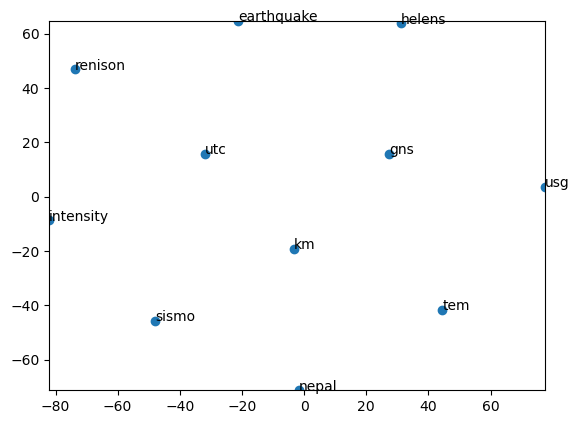

In [23]:
TSNE_10ClosestWords(cbow_model, 'earthquake', 512)

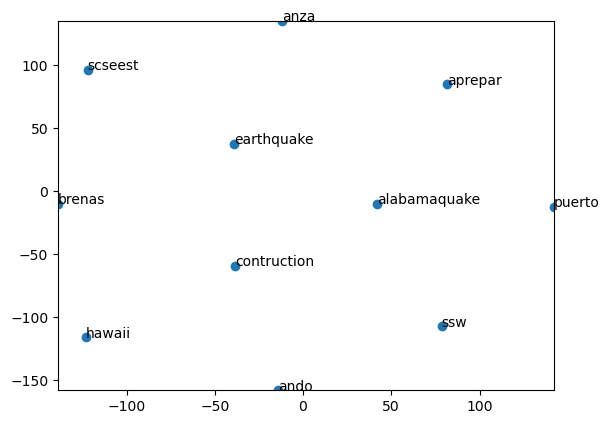

In [24]:
TSNE_10ClosestWords(skipgram_model, 'earthquake', 512)

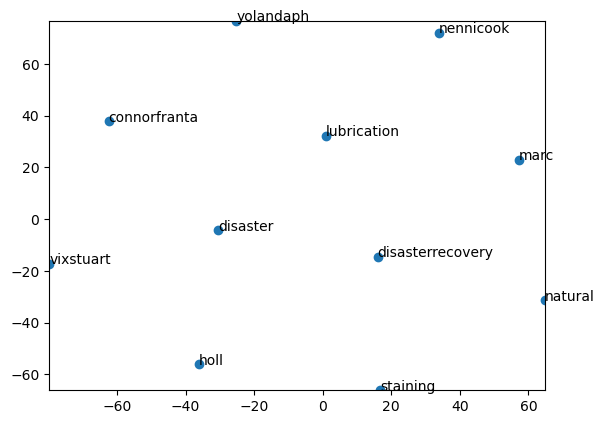

In [41]:
TSNE_10ClosestWords(cbow_model, 'disaster', 512)

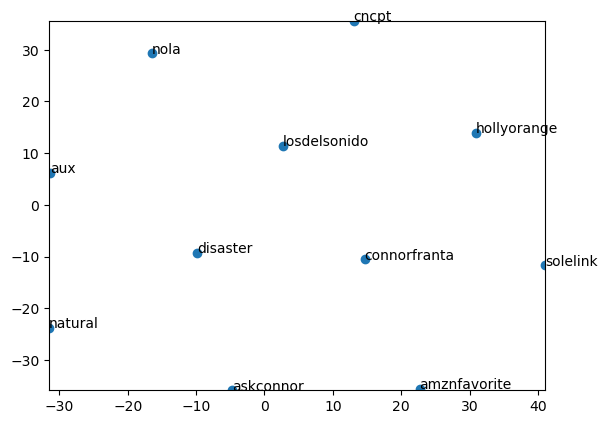

In [42]:
TSNE_10ClosestWords(skipgram_model, 'disaster', 512)

# Training models

## Fully-Connected Neural Network with TF-IDF features

In [28]:
# Convert the TF-IDF column to a torch tensor
X_train = torch.FloatTensor(tweets_train['TFIDF'].tolist())
# Convert the target column to a torch tensor
y_train = torch.FloatTensor(tweets_train['target'].tolist()).unsqueeze(1)

# Convert the TF-IDF column to a torch tensor
X_test = torch.FloatTensor(tweets_test['TFIDF'].tolist())
# Convert the target column to a torch tensor
y_test = torch.FloatTensor(tweets_test['target'].tolist()).unsqueeze(1)

In [29]:
# Create a torch Dataset object
TrainDatasetTFIDF = torch.utils.data.TensorDataset(X_train, y_train)
# Create a torch DataLoader object
TrainDataLoaderTFIDF = torch.utils.data.DataLoader(TrainDatasetTFIDF, batch_size = 1024)

# Create a torch Dataset object
TestDatasetTFIDF = torch.utils.data.TensorDataset(X_test, y_test)
# Create a torch DataLoader object
TestDataLoaderTFIDF = torch.utils.data.DataLoader(TestDatasetTFIDF, batch_size = 1024)

In [30]:
# Initialize the network, loss function, and optimizer
device = set_device()
customFCNN = CustomFCNN(input_size = X_train.shape[1], 
                        hidden_size = 2048, 
                        dropout_rate = 0.5).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customFCNN.parameters(), lr = 1e-5)

Device: mps


In [31]:
# Train the model
train_losses, train_f1s, test_losses, test_f1s = train(model = customFCNN, 
                                                       train_loader = TrainDataLoaderTFIDF, 
                                                       test_loader = TestDataLoaderTFIDF, 
                                                       optimizer = optimizer, 
                                                       loss_func = criterion, 
                                                       epochs = 16, 
                                                       device = device)

Epoch 1/16
======== Training phase ========
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loss = 0.7323 | Accuracy = 53.93% | F1-Score = 55.14% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00,  9.08it/s]


Training Cross-Entropy Loss = 0.7479
Training Accuracy = 51.77%
Training F1-Score = 48.51%
======== Validation phase ========


  0%|          | 0/4 [00:00<?, ?it/s]


RuntimeError: linear(): input and weight.T shapes cannot be multiplied (1024x6719 and 14687x2048)

## Training LSTM Neural Networks with Custom Pre-trained Word2Vec Embeddings

### **SkipGram embeddings**

#### Without attention

In [32]:
TrainTweetsDataset_SkipGram = TweetsDataset(tweets_train, 'skipgram')
# Create a dataloade for the training dataset
TrainDataLoader_SkipGram = torch.utils.data.DataLoader(dataset = TrainTweetsDataset_SkipGram, batch_size = 64, shuffle = True)

TestTweetsDataset_SkipGram = TweetsDataset(tweets_test, 'skipgram')
# Create a dataloade for the training dataset
TestDataLoader_SkipGram = torch.utils.data.DataLoader(dataset = TestTweetsDataset_SkipGram, batch_size = 64, shuffle = False)

In [34]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedLSTM = CustomLSTM(word2vec_model = skipgram_model,
                                  hidden_size = 64, 
                                  output_size = 1, 
                                  num_layers = 1, 
                                  bidirectional = True,
                                  freeze_embeddings = False).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedLSTM.parameters(), lr = 1e-4)

Device: mps


In [35]:
# Train the model
train_losses, train_f1s, test_losses, test_f1s = train(model = customPreTrainedLSTM, 
                                                       train_loader = TrainDataLoader_SkipGram, 
                                                       test_loader = TestDataLoader_SkipGram, 
                                                       optimizer = optimizer, 
                                                       loss_func = criterion, 
                                                       epochs = 8, 
                                                       device = device)

Epoch 1/8
======== Training phase ========


Loss = 0.6720 | Accuracy = 60.66% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.99it/s]


Training Cross-Entropy Loss = 0.6842
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7039 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 84.85it/s]


Test Cross-Entropy Loss = 0.6835
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/8
======== Training phase ========


Loss = 0.6641 | Accuracy = 68.85% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.85it/s]


Training Cross-Entropy Loss = 0.6847
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6956 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 101.37it/s]


Test Cross-Entropy Loss = 0.6846
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 3/8
======== Training phase ========


Loss = 0.7085 | Accuracy = 44.26% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.51it/s]


Training Cross-Entropy Loss = 0.6836
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6957 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 97.84it/s] 


Test Cross-Entropy Loss = 0.6846
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 4/8
======== Training phase ========


Loss = 0.6823 | Accuracy = 57.38% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.82it/s]


Training Cross-Entropy Loss = 0.6843
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7012 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 102.58it/s]


Test Cross-Entropy Loss = 0.6832
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 5/8
======== Training phase ========


Loss = 0.7235 | Accuracy = 44.26% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.56it/s]


Training Cross-Entropy Loss = 0.6838
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7025 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 102.57it/s]


Test Cross-Entropy Loss = 0.6833
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 6/8
======== Training phase ========


Loss = 0.6724 | Accuracy = 62.30% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.53it/s]


Training Cross-Entropy Loss = 0.6840
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6978 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 98.25it/s] 


Test Cross-Entropy Loss = 0.6836
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 7/8
======== Training phase ========


Loss = 0.7118 | Accuracy = 47.54% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.65it/s]


Training Cross-Entropy Loss = 0.6839
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7017 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 101.38it/s]


Test Cross-Entropy Loss = 0.6832
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 8/8
======== Training phase ========


Loss = 0.6825 | Accuracy = 57.38% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.54it/s]


Training Cross-Entropy Loss = 0.6834
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6989 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 103.86it/s]


Test Cross-Entropy Loss = 0.6834
Test Accuracy = 57.03%
Test F1-Score = 0.00%



#### With attention

In [36]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedLSTM_Attention = CustomLSTM_Attention(word2vec_model = skipgram_model, 
                                                      hidden_size = 64, 
                                                      output_size = 1, 
                                                      num_layers = 1, 
                                                      bidirectional = True,
                                                      freeze_embeddings = False).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedLSTM_Attention.parameters(), lr = 1e-4)

Device: mps


In [37]:
# Train the model
train_losses, train_f1s, test_losses, test_f1s = train(model = customPreTrainedLSTM_Attention, 
                                                       train_loader = TrainDataLoader_SkipGram, 
                                                       test_loader = TestDataLoader_SkipGram, 
                                                       optimizer = optimizer, 
                                                       loss_func = criterion, 
                                                       epochs = 8, 
                                                       device = device)

Epoch 1/8
======== Training phase ========


Loss = 0.6415 | Accuracy = 65.57% | F1-Score = 36.36% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 26.88it/s]


Training Cross-Entropy Loss = 0.6707
Training Accuracy = 57.77%
Training F1-Score = 12.28%
======== Validation phase ========


Loss = 0.6186 | Accuracy = 74.60% | F1-Score = 68.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 94.66it/s] 


Test Cross-Entropy Loss = 0.6484
Test Accuracy = 66.53%
Test F1-Score = 45.99%

Epoch 2/8
======== Training phase ========


Loss = 0.4540 | Accuracy = 77.05% | F1-Score = 63.16% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.90it/s]


Training Cross-Entropy Loss = 0.5621
Training Accuracy = 73.97%
Training F1-Score = 64.98%
======== Validation phase ========


Loss = 0.3753 | Accuracy = 87.30% | F1-Score = 85.71% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 99.37it/s] 


Test Cross-Entropy Loss = 0.5217
Test Accuracy = 75.76%
Test F1-Score = 66.86%

Epoch 3/8
======== Training phase ========


Loss = 0.3810 | Accuracy = 83.61% | F1-Score = 77.27% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.83it/s]


Training Cross-Entropy Loss = 0.4572
Training Accuracy = 79.60%
Training F1-Score = 74.53%
======== Validation phase ========


Loss = 0.3290 | Accuracy = 88.89% | F1-Score = 87.72% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 99.73it/s] 


Test Cross-Entropy Loss = 0.4786
Test Accuracy = 78.42%
Test F1-Score = 70.37%

Epoch 4/8
======== Training phase ========


Loss = 0.4183 | Accuracy = 80.33% | F1-Score = 71.43% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.94it/s]


Training Cross-Entropy Loss = 0.4173
Training Accuracy = 81.22%
Training F1-Score = 76.53%
======== Validation phase ========


Loss = 0.3229 | Accuracy = 88.89% | F1-Score = 87.72% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 99.10it/s] 


Test Cross-Entropy Loss = 0.4681
Test Accuracy = 78.95%
Test F1-Score = 70.78%

Epoch 5/8
======== Training phase ========


Loss = 0.3676 | Accuracy = 86.89% | F1-Score = 85.19% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.81it/s]


Training Cross-Entropy Loss = 0.3897
Training Accuracy = 83.00%
Training F1-Score = 78.98%
======== Validation phase ========


Loss = 0.3169 | Accuracy = 88.89% | F1-Score = 88.14% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 98.59it/s] 


Test Cross-Entropy Loss = 0.4555
Test Accuracy = 79.07%
Test F1-Score = 74.47%

Epoch 6/8
======== Training phase ========


Loss = 0.3159 | Accuracy = 86.89% | F1-Score = 84.62% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.90it/s]


Training Cross-Entropy Loss = 0.3627
Training Accuracy = 84.09%
Training F1-Score = 80.58%
======== Validation phase ========


Loss = 0.3233 | Accuracy = 87.30% | F1-Score = 86.21% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 100.94it/s]


Test Cross-Entropy Loss = 0.4559
Test Accuracy = 79.25%
Test F1-Score = 73.29%

Epoch 7/8
======== Training phase ========


Loss = 0.2938 | Accuracy = 88.52% | F1-Score = 86.79% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.98it/s]


Training Cross-Entropy Loss = 0.3341
Training Accuracy = 85.96%
Training F1-Score = 82.89%
======== Validation phase ========


Loss = 0.3359 | Accuracy = 87.30% | F1-Score = 86.21% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 99.45it/s] 


Test Cross-Entropy Loss = 0.4635
Test Accuracy = 79.04%
Test F1-Score = 73.18%

Epoch 8/8
======== Training phase ========


Loss = 0.2427 | Accuracy = 90.16% | F1-Score = 82.35% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.95it/s]


Training Cross-Entropy Loss = 0.3011
Training Accuracy = 87.71%
Training F1-Score = 85.15%
======== Validation phase ========


Loss = 0.3676 | Accuracy = 87.30% | F1-Score = 86.21% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 99.14it/s] 

Test Cross-Entropy Loss = 0.4942
Test Accuracy = 78.49%
Test F1-Score = 71.06%



#### With Multi-Head Attention

In [45]:
# Initialize the network, loss function, and optimizer
device = set_device()

customPreTrainedLSTM_MultiheadAttention = CustomLSTM_MultiHeadAttention(word2vec_model = skipgram_model,
                                                                        hidden_size = 64, 
                                                                        output_size = 1, 
                                                                        dropout = 0.3,
                                                                        num_layers = 1, 
                                                                        bidirectional = True,
                                                                        freeze_embeddings = False,
                                                                        num_heads = 8).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedLSTM_MultiheadAttention.parameters(), lr = 1e-4)

Device: mps


In [46]:
# Train the model
train_losses, train_f1s, test_losses, test_f1s = train(model = customPreTrainedLSTM_MultiheadAttention, 
                                                       train_loader = TrainDataLoader_SkipGram, 
                                                       test_loader = TestDataLoader_SkipGram, 
                                                       optimizer = optimizer, 
                                                       loss_func = criterion, 
                                                       epochs = 16, 
                                                       device = device)

Epoch 1/16
======== Training phase ========


Loss = 0.6149 | Accuracy = 68.85% | F1-Score = 61.22% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 24.75it/s]


Training Cross-Entropy Loss = 0.6246
Training Accuracy = 66.96%
Training F1-Score = 62.22%
======== Validation phase ========


Loss = 0.7029 | Accuracy = 63.49% | F1-Score = 41.03% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 83.01it/s] 


Test Cross-Entropy Loss = 0.8672
Test Accuracy = 63.44%
Test F1-Score = 26.49%

Epoch 2/16
======== Training phase ========


Loss = 0.5737 | Accuracy = 73.77% | F1-Score = 71.43% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.34it/s]


Training Cross-Entropy Loss = 0.5122
Training Accuracy = 76.33%
Training F1-Score = 72.05%
======== Validation phase ========


Loss = 0.3330 | Accuracy = 88.89% | F1-Score = 87.27% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 83.73it/s]


Test Cross-Entropy Loss = 0.5044
Test Accuracy = 76.65%
Test F1-Score = 66.37%

Epoch 3/16
======== Training phase ========


Loss = 0.4045 | Accuracy = 85.25% | F1-Score = 81.63% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.19it/s]


Training Cross-Entropy Loss = 0.4626
Training Accuracy = 79.35%
Training F1-Score = 75.32%
======== Validation phase ========


Loss = 0.3615 | Accuracy = 84.13% | F1-Score = 84.38% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 84.68it/s] 


Test Cross-Entropy Loss = 0.4867
Test Accuracy = 76.89%
Test F1-Score = 74.05%

Epoch 4/16
======== Training phase ========


Loss = 0.4158 | Accuracy = 81.97% | F1-Score = 78.43% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.33it/s]


Training Cross-Entropy Loss = 0.4210
Training Accuracy = 81.32%
Training F1-Score = 77.28%
======== Validation phase ========


Loss = 0.3331 | Accuracy = 84.13% | F1-Score = 83.87% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 84.63it/s] 


Test Cross-Entropy Loss = 0.4645
Test Accuracy = 78.27%
Test F1-Score = 74.15%

Epoch 5/16
======== Training phase ========


Loss = 0.3853 | Accuracy = 85.25% | F1-Score = 82.35% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.28it/s]


Training Cross-Entropy Loss = 0.3805
Training Accuracy = 83.46%
Training F1-Score = 79.85%
======== Validation phase ========


Loss = 0.6926 | Accuracy = 63.49% | F1-Score = 71.60% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 83.85it/s] 


Test Cross-Entropy Loss = 0.9655
Test Accuracy = 51.55%
Test F1-Score = 63.39%

Epoch 6/16
======== Training phase ========


Loss = 0.3032 | Accuracy = 85.25% | F1-Score = 84.21% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.30it/s]


Training Cross-Entropy Loss = 0.3345
Training Accuracy = 86.00%
Training F1-Score = 83.15%
======== Validation phase ========


Loss = 0.4451 | Accuracy = 82.54% | F1-Score = 84.06% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 83.34it/s] 


Test Cross-Entropy Loss = 0.6045
Test Accuracy = 70.89%
Test F1-Score = 71.64%

Epoch 7/16
======== Training phase ========


Loss = 0.1269 | Accuracy = 96.72% | F1-Score = 96.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.30it/s]


Training Cross-Entropy Loss = 0.2730
Training Accuracy = 88.86%
Training F1-Score = 86.72%
======== Validation phase ========


Loss = 0.5011 | Accuracy = 80.95% | F1-Score = 82.86% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 85.85it/s]


Test Cross-Entropy Loss = 0.6368
Test Accuracy = 70.82%
Test F1-Score = 70.99%

Epoch 8/16
======== Training phase ========


Loss = 0.2268 | Accuracy = 88.52% | F1-Score = 86.27% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.27it/s]


Training Cross-Entropy Loss = 0.2248
Training Accuracy = 91.33%
Training F1-Score = 89.76%
======== Validation phase ========


Loss = 0.4087 | Accuracy = 90.48% | F1-Score = 89.29% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 83.54it/s] 


Test Cross-Entropy Loss = 0.6556
Test Accuracy = 77.75%
Test F1-Score = 68.71%

Epoch 9/16
======== Training phase ========


Loss = 0.1791 | Accuracy = 95.08% | F1-Score = 93.88% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.28it/s]


Training Cross-Entropy Loss = 0.1788
Training Accuracy = 93.58%
Training F1-Score = 92.41%
======== Validation phase ========


Loss = 0.5318 | Accuracy = 80.95% | F1-Score = 82.35% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 84.82it/s] 


Test Cross-Entropy Loss = 0.7262
Test Accuracy = 73.06%
Test F1-Score = 72.35%

Epoch 10/16
======== Training phase ========


Loss = 0.2847 | Accuracy = 86.89% | F1-Score = 82.61% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.30it/s]


Training Cross-Entropy Loss = 0.1438
Training Accuracy = 94.97%
Training F1-Score = 94.08%
======== Validation phase ========


Loss = 0.5090 | Accuracy = 80.95% | F1-Score = 81.25% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 84.59it/s] 


Test Cross-Entropy Loss = 0.6731
Test Accuracy = 74.84%
Test F1-Score = 71.44%

Epoch 11/16
======== Training phase ========


Loss = 0.0929 | Accuracy = 95.08% | F1-Score = 94.34% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.25it/s]


Training Cross-Entropy Loss = 0.1193
Training Accuracy = 95.78%
Training F1-Score = 95.09%
======== Validation phase ========


Loss = 0.8476 | Accuracy = 84.13% | F1-Score = 80.77% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 86.14it/s]


Test Cross-Entropy Loss = 1.2917
Test Accuracy = 72.26%
Test F1-Score = 54.55%

Epoch 12/16
======== Training phase ========


Loss = 0.2640 | Accuracy = 88.52% | F1-Score = 87.72% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.23it/s]  


Training Cross-Entropy Loss = 0.1070
Training Accuracy = 96.20%
Training F1-Score = 95.55%
======== Validation phase ========


Loss = 0.5682 | Accuracy = 82.54% | F1-Score = 82.54% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 83.65it/s] 


Test Cross-Entropy Loss = 0.7138
Test Accuracy = 76.77%
Test F1-Score = 71.24%

Epoch 13/16
======== Training phase ========


Loss = 0.1847 | Accuracy = 95.08% | F1-Score = 94.74% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.28it/s]  


Training Cross-Entropy Loss = 0.0909
Training Accuracy = 97.11%
Training F1-Score = 96.61%
======== Validation phase ========


Loss = 0.6824 | Accuracy = 80.95% | F1-Score = 81.25% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 84.57it/s] 


Test Cross-Entropy Loss = 0.8885
Test Accuracy = 72.20%
Test F1-Score = 71.01%

Epoch 14/16
======== Training phase ========


Loss = 0.1179 | Accuracy = 96.72% | F1-Score = 95.65% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.32it/s] 


Training Cross-Entropy Loss = 0.0878
Training Accuracy = 96.97%
Training F1-Score = 96.46%
======== Validation phase ========


Loss = 0.6021 | Accuracy = 87.30% | F1-Score = 86.21% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 86.81it/s] 


Test Cross-Entropy Loss = 0.8728
Test Accuracy = 76.56%
Test F1-Score = 67.76%

Epoch 15/16
======== Training phase ========


Loss = 0.0283 | Accuracy = 100.00% | F1-Score = 100.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.30it/s]


Training Cross-Entropy Loss = 0.0807
Training Accuracy = 97.43%
Training F1-Score = 96.98%
======== Validation phase ========


Loss = 0.5593 | Accuracy = 85.71% | F1-Score = 85.25% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 83.18it/s]


Test Cross-Entropy Loss = 0.8447
Test Accuracy = 76.52%
Test F1-Score = 70.29%

Epoch 16/16
======== Training phase ========


Loss = 0.0462 | Accuracy = 98.36% | F1-Score = 97.87% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.31it/s]  


Training Cross-Entropy Loss = 0.0765
Training Accuracy = 97.18%
Training F1-Score = 96.70%
======== Validation phase ========


Loss = 0.6099 | Accuracy = 82.54% | F1-Score = 82.54% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 86.41it/s] 


Test Cross-Entropy Loss = 0.8627
Test Accuracy = 72.42%
Test F1-Score = 70.53%



### **CBOW embeddings**

#### Without attention

In [47]:
TrainTweetsDataset_CBOW = TweetsDataset(tweets_train, 'cbow')
# Create a dataloade for the training dataset
TrainDataLoader_CBOW = torch.utils.data.DataLoader(dataset = TrainTweetsDataset_CBOW, batch_size = 64, shuffle = True)

TestTweetsDataset_CBOW = TweetsDataset(tweets_test, 'cbow')
# Create a dataloade for the training dataset
TestDataLoader_CBOW = torch.utils.data.DataLoader(dataset = TestTweetsDataset_CBOW, batch_size = 64, shuffle = False)

In [48]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedLSTM = CustomLSTM(word2vec_model = cbow_model,
                                  hidden_size = 64, 
                                  output_size = 1, 
                                  num_layers = 1, 
                                  bidirectional = True,
                                  freeze_embeddings = False).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedLSTM.parameters(), lr = 1e-4)

Device: mps


In [49]:
# Train the model
train_losses, train_f1s, test_losses, test_f1s = train(model = customPreTrainedLSTM, 
                                                       train_loader = TrainDataLoader_CBOW, 
                                                       test_loader = TestDataLoader_CBOW, 
                                                       optimizer = optimizer, 
                                                       loss_func = criterion, 
                                                       epochs = 8, 
                                                       device = device)

Epoch 1/8
======== Training phase ========


Loss = 0.6822 | Accuracy = 57.38% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 26.89it/s]


Training Cross-Entropy Loss = 0.6833
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7032 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 98.05it/s] 


Test Cross-Entropy Loss = 0.6834
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/8
======== Training phase ========


Loss = 0.6831 | Accuracy = 57.38% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.75it/s]


Training Cross-Entropy Loss = 0.6839
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6976 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 97.09it/s] 


Test Cross-Entropy Loss = 0.6837
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 3/8
======== Training phase ========


Loss = 0.6726 | Accuracy = 62.30% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.41it/s]


Training Cross-Entropy Loss = 0.6842
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6974 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 99.76it/s] 


Test Cross-Entropy Loss = 0.6837
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 4/8
======== Training phase ========


Loss = 0.6652 | Accuracy = 63.93% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.72it/s]


Training Cross-Entropy Loss = 0.6838
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7000 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 98.76it/s] 


Test Cross-Entropy Loss = 0.6833
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 5/8
======== Training phase ========


Loss = 0.7033 | Accuracy = 50.82% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.88it/s]


Training Cross-Entropy Loss = 0.6836
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7037 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 97.60it/s] 


Test Cross-Entropy Loss = 0.6834
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 6/8
======== Training phase ========


Loss = 0.6994 | Accuracy = 50.82% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.68it/s]


Training Cross-Entropy Loss = 0.6839
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6999 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 96.02it/s] 


Test Cross-Entropy Loss = 0.6833
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 7/8
======== Training phase ========


Loss = 0.7199 | Accuracy = 44.26% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.29it/s]


Training Cross-Entropy Loss = 0.6841
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7008 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 100.84it/s]


Test Cross-Entropy Loss = 0.6832
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 8/8
======== Training phase ========


Loss = 0.6994 | Accuracy = 49.18% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.71it/s]


Training Cross-Entropy Loss = 0.6835
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6959 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 102.96it/s]

Test Cross-Entropy Loss = 0.6844
Test Accuracy = 57.03%
Test F1-Score = 0.00%



#### With attention

In [50]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedLSTM_Attention = CustomLSTM_Attention(word2vec_model = cbow_model, 
                                                      hidden_size = 64, 
                                                      output_size = 1, 
                                                      num_layers = 1, 
                                                      bidirectional = True,
                                                      freeze_embeddings = False).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(customPreTrainedLSTM_Attention.parameters(), lr = 1e-4)

Device: mps


In [51]:
# Train the model
train_losses, train_f1s, test_losses, test_f1s = train(model = customPreTrainedLSTM_Attention, 
                                                       train_loader = TrainDataLoader_CBOW, 
                                                       test_loader = TestDataLoader_CBOW, 
                                                       optimizer = optimizer, 
                                                       loss_func = criterion, 
                                                       epochs = 8, 
                                                       device = device)

Epoch 1/8
======== Training phase ========


Loss = 0.6054 | Accuracy = 75.41% | F1-Score = 54.55% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.32it/s]


Training Cross-Entropy Loss = 0.6590
Training Accuracy = 60.15%
Training F1-Score = 15.58%
======== Validation phase ========


Loss = 0.5571 | Accuracy = 80.95% | F1-Score = 76.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 88.52it/s] 


Test Cross-Entropy Loss = 0.6130
Test Accuracy = 72.54%
Test F1-Score = 56.80%

Epoch 2/8
======== Training phase ========


Loss = 0.5145 | Accuracy = 73.77% | F1-Score = 61.90% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.46it/s]


Training Cross-Entropy Loss = 0.5268
Training Accuracy = 77.43%
Training F1-Score = 69.93%
======== Validation phase ========


Loss = 0.3611 | Accuracy = 90.48% | F1-Score = 89.66% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 92.71it/s] 


Test Cross-Entropy Loss = 0.5043
Test Accuracy = 77.38%
Test F1-Score = 71.75%

Epoch 3/8
======== Training phase ========


Loss = 0.5660 | Accuracy = 70.49% | F1-Score = 70.97% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.35it/s]


Training Cross-Entropy Loss = 0.4585
Training Accuracy = 79.97%
Training F1-Score = 75.23%
======== Validation phase ========


Loss = 0.3298 | Accuracy = 90.48% | F1-Score = 89.66% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 95.34it/s] 


Test Cross-Entropy Loss = 0.4754
Test Accuracy = 78.64%
Test F1-Score = 73.28%

Epoch 4/8
======== Training phase ========


Loss = 0.3986 | Accuracy = 81.97% | F1-Score = 74.42% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.13it/s]


Training Cross-Entropy Loss = 0.4308
Training Accuracy = 81.15%
Training F1-Score = 76.77%
======== Validation phase ========


Loss = 0.3263 | Accuracy = 90.48% | F1-Score = 89.66% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 96.88it/s] 


Test Cross-Entropy Loss = 0.4616
Test Accuracy = 79.16%
Test F1-Score = 74.22%

Epoch 5/8
======== Training phase ========


Loss = 0.5685 | Accuracy = 72.13% | F1-Score = 65.31% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.66it/s]


Training Cross-Entropy Loss = 0.4135
Training Accuracy = 82.19%
Training F1-Score = 78.27%
======== Validation phase ========


Loss = 0.3257 | Accuracy = 90.48% | F1-Score = 89.66% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 98.95it/s] 


Test Cross-Entropy Loss = 0.4550
Test Accuracy = 79.77%
Test F1-Score = 74.42%

Epoch 6/8
======== Training phase ========


Loss = 0.5272 | Accuracy = 78.69% | F1-Score = 75.47% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.61it/s]


Training Cross-Entropy Loss = 0.3975
Training Accuracy = 82.85%
Training F1-Score = 79.01%
======== Validation phase ========


Loss = 0.3263 | Accuracy = 90.48% | F1-Score = 89.66% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 98.63it/s] 


Test Cross-Entropy Loss = 0.4486
Test Accuracy = 80.05%
Test F1-Score = 74.82%

Epoch 7/8
======== Training phase ========


Loss = 0.4757 | Accuracy = 80.33% | F1-Score = 73.91% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.65it/s]


Training Cross-Entropy Loss = 0.3814
Training Accuracy = 83.59%
Training F1-Score = 80.01%
======== Validation phase ========


Loss = 0.3309 | Accuracy = 88.89% | F1-Score = 88.14% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 97.84it/s] 


Test Cross-Entropy Loss = 0.4444
Test Accuracy = 80.05%
Test F1-Score = 75.16%

Epoch 8/8
======== Training phase ========


Loss = 0.4634 | Accuracy = 77.05% | F1-Score = 75.86% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 27.57it/s]


Training Cross-Entropy Loss = 0.3657
Training Accuracy = 84.43%
Training F1-Score = 80.95%
======== Validation phase ========


Loss = 0.3304 | Accuracy = 88.89% | F1-Score = 88.14% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 98.06it/s] 


Test Cross-Entropy Loss = 0.4418
Test Accuracy = 80.17%
Test F1-Score = 75.37%



#### With Multi-Head Attention

In [54]:
# Initialize the network, loss function, and optimizer
device = set_device()

customPreTrainedLSTM_MultiheadAttention = CustomLSTM_MultiHeadAttention(word2vec_model = cbow_model,
                                                                        hidden_size = 64, 
                                                                        output_size = 1, 
                                                                        dropout = 0.2,
                                                                        num_layers = 1, 
                                                                        bidirectional = True,
                                                                        freeze_embeddings = False,
                                                                        num_heads = 8).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedLSTM_MultiheadAttention.parameters(), lr = 1e-4)

Device: mps


In [55]:
# Train the model
train_losses, train_f1s, test_losses, test_f1s = train(model = customPreTrainedLSTM_MultiheadAttention, 
                                                       train_loader = TrainDataLoader_CBOW, 
                                                       test_loader = TestDataLoader_CBOW, 
                                                       optimizer = optimizer, 
                                                       loss_func = criterion, 
                                                       epochs = 16, 
                                                       device = device)

Epoch 1/16
======== Training phase ========


Loss = 0.4239 | Accuracy = 81.97% | F1-Score = 77.55% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 24.91it/s]


Training Cross-Entropy Loss = 0.5627
Training Accuracy = 72.42%
Training F1-Score = 68.33%
======== Validation phase ========


Loss = 1.2338 | Accuracy = 50.79% | F1-Score = 66.67% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 84.71it/s] 


Test Cross-Entropy Loss = 1.5029
Test Accuracy = 44.62%
Test F1-Score = 60.64%

Epoch 2/16
======== Training phase ========


Loss = 0.4427 | Accuracy = 75.41% | F1-Score = 66.67% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 24.83it/s]


Training Cross-Entropy Loss = 0.4917
Training Accuracy = 77.41%
Training F1-Score = 72.92%
======== Validation phase ========


Loss = 0.4907 | Accuracy = 79.37% | F1-Score = 73.47% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 89.16it/s] 


Test Cross-Entropy Loss = 0.6941
Test Accuracy = 71.71%
Test F1-Score = 52.59%

Epoch 3/16
======== Training phase ========


Loss = 0.4230 | Accuracy = 80.33% | F1-Score = 77.78% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 24.92it/s]


Training Cross-Entropy Loss = 0.4414
Training Accuracy = 80.64%
Training F1-Score = 76.48%
======== Validation phase ========


Loss = 0.3217 | Accuracy = 90.48% | F1-Score = 89.29% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 81.90it/s] 


Test Cross-Entropy Loss = 0.4844
Test Accuracy = 77.47%
Test F1-Score = 69.00%

Epoch 4/16
======== Training phase ========


Loss = 0.3269 | Accuracy = 86.89% | F1-Score = 82.61% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.09it/s]


Training Cross-Entropy Loss = 0.4119
Training Accuracy = 81.91%
Training F1-Score = 77.87%
======== Validation phase ========


Loss = 0.3008 | Accuracy = 88.89% | F1-Score = 88.52% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 83.43it/s]


Test Cross-Entropy Loss = 0.4666
Test Accuracy = 78.00%
Test F1-Score = 73.87%

Epoch 5/16
======== Training phase ========


Loss = 0.2941 | Accuracy = 91.80% | F1-Score = 89.36% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.17it/s]


Training Cross-Entropy Loss = 0.3738
Training Accuracy = 83.61%
Training F1-Score = 80.09%
======== Validation phase ========


Loss = 0.5153 | Accuracy = 71.43% | F1-Score = 75.68% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 84.23it/s] 


Test Cross-Entropy Loss = 0.7415
Test Accuracy = 62.98%
Test F1-Score = 68.16%

Epoch 6/16
======== Training phase ========


Loss = 0.3787 | Accuracy = 81.97% | F1-Score = 78.43% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.27it/s]


Training Cross-Entropy Loss = 0.3234
Training Accuracy = 86.13%
Training F1-Score = 83.28%
======== Validation phase ========


Loss = 0.3535 | Accuracy = 85.71% | F1-Score = 85.71% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 84.58it/s] 


Test Cross-Entropy Loss = 0.5324
Test Accuracy = 75.33%
Test F1-Score = 73.09%

Epoch 7/16
======== Training phase ========


Loss = 0.2615 | Accuracy = 91.80% | F1-Score = 90.57% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.28it/s]


Training Cross-Entropy Loss = 0.2733
Training Accuracy = 88.80%
Training F1-Score = 86.53%
======== Validation phase ========


Loss = 0.4514 | Accuracy = 87.30% | F1-Score = 86.21% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 86.61it/s] 


Test Cross-Entropy Loss = 0.6582
Test Accuracy = 76.77%
Test F1-Score = 66.52%

Epoch 8/16
======== Training phase ========


Loss = 0.2663 | Accuracy = 88.52% | F1-Score = 87.72% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.15it/s]


Training Cross-Entropy Loss = 0.2235
Training Accuracy = 91.16%
Training F1-Score = 89.53%
======== Validation phase ========


Loss = 0.4642 | Accuracy = 85.71% | F1-Score = 84.75% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 85.98it/s] 


Test Cross-Entropy Loss = 0.6227
Test Accuracy = 77.38%
Test F1-Score = 70.46%

Epoch 9/16
======== Training phase ========


Loss = 0.1271 | Accuracy = 95.08% | F1-Score = 93.62% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.32it/s]  


Training Cross-Entropy Loss = 0.1762
Training Accuracy = 93.56%
Training F1-Score = 92.40%
======== Validation phase ========


Loss = 0.4344 | Accuracy = 84.13% | F1-Score = 83.87% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 85.77it/s] 


Test Cross-Entropy Loss = 0.6592
Test Accuracy = 74.35%
Test F1-Score = 70.25%

Epoch 10/16
======== Training phase ========


Loss = 0.1365 | Accuracy = 93.44% | F1-Score = 91.30% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.24it/s]


Training Cross-Entropy Loss = 0.1483
Training Accuracy = 94.79%
Training F1-Score = 93.90%
======== Validation phase ========


Loss = 1.0231 | Accuracy = 80.95% | F1-Score = 76.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 86.07it/s]


Test Cross-Entropy Loss = 1.4916
Test Accuracy = 70.73%
Test F1-Score = 49.28%

Epoch 11/16
======== Training phase ========


Loss = 0.1253 | Accuracy = 95.08% | F1-Score = 94.34% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.23it/s]


Training Cross-Entropy Loss = 0.1282
Training Accuracy = 95.60%
Training F1-Score = 94.85%
======== Validation phase ========


Loss = 0.9901 | Accuracy = 68.25% | F1-Score = 74.36% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 72.59it/s]


Test Cross-Entropy Loss = 1.2781
Test Accuracy = 59.36%
Test F1-Score = 65.43%

Epoch 12/16
======== Training phase ========


Loss = 0.0968 | Accuracy = 95.08% | F1-Score = 94.12% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.05it/s]  


Training Cross-Entropy Loss = 0.1189
Training Accuracy = 95.84%
Training F1-Score = 95.13%
======== Validation phase ========


Loss = 0.5950 | Accuracy = 85.71% | F1-Score = 86.57% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 91.45it/s] 


Test Cross-Entropy Loss = 0.9149
Test Accuracy = 68.56%
Test F1-Score = 69.13%

Epoch 13/16
======== Training phase ========


Loss = 0.0778 | Accuracy = 98.36% | F1-Score = 98.18% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.36it/s]  


Training Cross-Entropy Loss = 0.1058
Training Accuracy = 96.48%
Training F1-Score = 95.88%
======== Validation phase ========


Loss = 0.6034 | Accuracy = 85.71% | F1-Score = 84.75% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 92.00it/s] 


Test Cross-Entropy Loss = 0.8655
Test Accuracy = 76.31%
Test F1-Score = 67.75%

Epoch 14/16
======== Training phase ========


Loss = 0.1000 | Accuracy = 95.08% | F1-Score = 95.38% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.03it/s]  


Training Cross-Entropy Loss = 0.0952
Training Accuracy = 97.01%
Training F1-Score = 96.51%
======== Validation phase ========


Loss = 0.4853 | Accuracy = 85.71% | F1-Score = 85.71% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 91.89it/s] 


Test Cross-Entropy Loss = 0.8357
Test Accuracy = 71.77%
Test F1-Score = 70.60%

Epoch 15/16
======== Training phase ========


Loss = 0.1496 | Accuracy = 96.72% | F1-Score = 96.30% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.12it/s]  


Training Cross-Entropy Loss = 0.0873
Training Accuracy = 97.08%
Training F1-Score = 96.59%
======== Validation phase ========


Loss = 0.4881 | Accuracy = 87.30% | F1-Score = 86.67% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 79.45it/s] 


Test Cross-Entropy Loss = 0.7957
Test Accuracy = 75.48%
Test F1-Score = 71.57%

Epoch 16/16
======== Training phase ========


Loss = 0.1726 | Accuracy = 93.44% | F1-Score = 90.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 25.06it/s]  


Training Cross-Entropy Loss = 0.0835
Training Accuracy = 97.35%
Training F1-Score = 96.90%
======== Validation phase ========


Loss = 0.6835 | Accuracy = 80.95% | F1-Score = 81.82% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 83.49it/s]

Test Cross-Entropy Loss = 1.0553
Test Accuracy = 68.00%
Test F1-Score = 69.26%



## Training GRU Neural Networks with Custom Pre-trained Word2Vec Embeddings

### **SkipGram Embeddings**

#### Without attention

In [27]:
TrainTweetsDataset_SkipGram = TweetsDataset(tweets_train, 'skipgram')
# Create a dataloade for the training dataset
TrainDataLoader_SkipGram = torch.utils.data.DataLoader(dataset = TrainTweetsDataset_SkipGram, batch_size = 32, shuffle = True)

TestTweetsDataset_SkipGram = TweetsDataset(tweets_test, 'skipgram')
# Create a dataloade for the training dataset
TestDataLoader_SkipGram = torch.utils.data.DataLoader(dataset = TestTweetsDataset_SkipGram, batch_size = 32, shuffle = False)

In [28]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedGRU = CustomGRU(word2vec_model = skipgram_model, 
                                hidden_size = 64, 
                                output_size = 1, 
                                num_layers = 1, 
                                bidirectional = True,
                                freeze_embeddings = False).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedGRU.parameters(), lr = 1e-4, weight_decay = 1e-5)

Device: mps


In [29]:
# Train the model
train_losses, train_f1s, test_losses, test_f1s = train(model = customPreTrainedGRU, 
                                                       train_loader = TrainDataLoader_SkipGram, 
                                                       test_loader = TestDataLoader_SkipGram, 
                                                       optimizer = optimizer, 
                                                       loss_func = criterion, 
                                                       epochs = 8, 
                                                       device = device)

Epoch 1/8
======== Training phase ========
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loss = nan | Accuracy = 44.83% | F1-Score = 0.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:50<00:00,  4.75it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 29.03% | F1-Score = 0.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:07<00:00, 13.77it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/8
======== Training phase ========


Loss = nan | Accuracy = 62.07% | F1-Score = 0.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:48<00:00,  4.91it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 29.03% | F1-Score = 0.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:07<00:00, 14.33it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 3/8
======== Training phase ========


Loss = nan | Accuracy = 51.72% | F1-Score = 0.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:48<00:00,  4.88it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 29.03% | F1-Score = 0.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:07<00:00, 14.27it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 4/8
======== Training phase ========


Loss = nan | Accuracy = 65.52% | F1-Score = 0.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:48<00:00,  4.95it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 29.03% | F1-Score = 0.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:07<00:00, 14.07it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 5/8
======== Training phase ========


Loss = nan | Accuracy = 41.38% | F1-Score = 0.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:48<00:00,  4.93it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 29.03% | F1-Score = 0.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:07<00:00, 14.24it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 6/8
======== Training phase ========


Loss = nan | Accuracy = 41.38% | F1-Score = 0.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:48<00:00,  4.92it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 29.03% | F1-Score = 0.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:07<00:00, 14.18it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 7/8
======== Training phase ========


Loss = nan | Accuracy = 51.72% | F1-Score = 0.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:51<00:00,  4.66it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 29.03% | F1-Score = 0.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:07<00:00, 13.68it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 8/8
======== Training phase ========


Loss = nan | Accuracy = 51.72% | F1-Score = 0.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:48<00:00,  4.90it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 29.03% | F1-Score = 0.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:07<00:00, 14.05it/s]

Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%



#### With attention

In [30]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedGRU_Attention = CustomGRU_Attention(word2vec_model = skipgram_model, 
                                                    hidden_size = 64, 
                                                    output_size = 1, 
                                                    num_layers = 1, 
                                                    bidirectional = True,
                                                    freeze_embeddings = False).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedGRU_Attention.parameters(), lr = 1e-4, weight_decay = 1e-5)

Device: mps


In [31]:
# Train the model
train_losses, train_f1s, test_losses, test_f1s = train(model = customPreTrainedGRU_Attention, 
                                                       train_loader = TrainDataLoader_SkipGram, 
                                                       test_loader = TestDataLoader_SkipGram, 
                                                       optimizer = optimizer, 
                                                       loss_func = criterion, 
                                                       epochs = 4, 
                                                       device = device)

Epoch 1/4
======== Training phase ========


Loss = nan | Accuracy = 68.97% | F1-Score = 0.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:49<00:00,  4.83it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 29.03% | F1-Score = 0.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:07<00:00, 13.91it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/4
======== Training phase ========


Loss = nan | Accuracy = 55.17% | F1-Score = 0.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:49<00:00,  4.81it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 29.03% | F1-Score = 0.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:07<00:00, 14.04it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 3/4
======== Training phase ========


Loss = nan | Accuracy = 58.62% | F1-Score = 0.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:49<00:00,  4.84it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 29.03% | F1-Score = 0.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:07<00:00, 14.08it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 4/4
======== Training phase ========


Loss = nan | Accuracy = 58.62% | F1-Score = 0.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:49<00:00,  4.85it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 29.03% | F1-Score = 0.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:07<00:00, 14.05it/s]

Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%



### **CBOW Embeddings**

#### Without attention

In [32]:
TrainTweetsDataset_CBOW = TweetsDataset(tweets_train, 'cbow')
# Create a dataloade for the training dataset
TrainDataLoader_CBOW = torch.utils.data.DataLoader(dataset = TrainTweetsDataset_CBOW, batch_size = 32, shuffle = True)

TestTweetsDataset_CBOW = TweetsDataset(tweets_test, 'cbow')
# Create a dataloade for the training dataset
TestDataLoader_CBOW = torch.utils.data.DataLoader(dataset = TestTweetsDataset_CBOW, batch_size = 32, shuffle = False)

In [33]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedGRU = CustomGRU(word2vec_model = cbow_model, 
                                hidden_size = 64, 
                                output_size = 1, 
                                num_layers = 1, 
                                bidirectional = True,
                                freeze_embeddings = False).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedGRU.parameters(), lr = 1e-4)

Device: mps


In [34]:
# Train the model
train_losses, train_f1s, test_losses, test_f1s = train(model = customPreTrainedGRU, 
                                                       train_loader = TrainDataLoader_CBOW, 
                                                       test_loader = TestDataLoader_CBOW, 
                                                       optimizer = optimizer, 
                                                       loss_func = criterion, 
                                                       epochs = 4, 
                                                       device = device)

Epoch 1/4
======== Training phase ========


Loss = nan | Accuracy = 72.41% | F1-Score = 0.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:48<00:00,  4.90it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 29.03% | F1-Score = 0.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:07<00:00, 14.07it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/4
======== Training phase ========


Loss = nan | Accuracy = 37.93% | F1-Score = 0.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:48<00:00,  4.94it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 29.03% | F1-Score = 0.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:07<00:00, 14.25it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 3/4
======== Training phase ========


Loss = nan | Accuracy = 55.17% | F1-Score = 0.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:50<00:00,  4.75it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 29.03% | F1-Score = 0.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:07<00:00, 13.73it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 4/4
======== Training phase ========


Loss = nan | Accuracy = 44.83% | F1-Score = 0.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:49<00:00,  4.84it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 29.03% | F1-Score = 0.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:07<00:00, 14.35it/s]

Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%



#### With attention

In [35]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedGRU_Attention = CustomGRU_Attention(word2vec_model = cbow_model, 
                                                    hidden_size = 64, 
                                                    output_size = 1, 
                                                    num_layers = 1, 
                                                    bidirectional = True,
                                                    freeze_embeddings = False).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedGRU_Attention.parameters(), lr = 1e-4)

Device: mps


In [36]:
# Train the model
train_losses, train_f1s, test_losses, test_f1s = train(model = customPreTrainedGRU_Attention, 
                                                       train_loader = TrainDataLoader_CBOW, 
                                                       test_loader = TestDataLoader_CBOW, 
                                                       optimizer = optimizer, 
                                                       loss_func = criterion, 
                                                       epochs = 4, 
                                                       device = device)

Epoch 1/4
======== Training phase ========


Loss = nan | Accuracy = 65.52% | F1-Score = 0.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:47<00:00,  4.98it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 29.03% | F1-Score = 0.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:07<00:00, 14.39it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/4
======== Training phase ========


Loss = nan | Accuracy = 51.72% | F1-Score = 0.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:47<00:00,  4.96it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 29.03% | F1-Score = 0.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:07<00:00, 14.30it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 3/4
======== Training phase ========


Loss = nan | Accuracy = 68.97% | F1-Score = 0.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:47<00:00,  4.98it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 29.03% | F1-Score = 0.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:07<00:00, 14.20it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 4/4
======== Training phase ========


Loss = nan | Accuracy = 72.41% | F1-Score = 0.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:48<00:00,  4.95it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 29.03% | F1-Score = 0.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:07<00:00, 14.17it/s]

Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%



## Training Encoder Transformers with Custom Pre-trained Word2Vec Embeddings

### SkipGram Embeddings

In [69]:
# Create a torch Dataset object for the training data
TrainDatasetEncoder = TweetsDatasetEncoderTransformer(tweets_train, 'skipgram', attn_masks_train)
# Create a torch Dataset object for the test data
TestDatasetEncoder = TweetsDatasetEncoderTransformer(tweets_test, 'skipgram', attn_masks_test)

# Create a torch DataLoader object for the training data
TrainDataLoaderEncoder = torch.utils.data.DataLoader(dataset = TrainDatasetEncoder, batch_size = 32, shuffle = True)
# Create a torch DataLoader object for the test data
TestDataLoaderEncoder = torch.utils.data.DataLoader(dataset = TestDatasetEncoder, batch_size = 32, shuffle = False)

In [70]:
# Initialize the network, loss function, and optimizer
device = set_device()
TransformerEncoder = EncoderTransformer(word2vec_model = skipgram_model,
                                        d_model = 512,
                                        num_heads = 16,
                                        num_layers = 8,
                                        d_ff = 2048,
                                        max_seq_length = 50,
                                        dropout = 0.1,
                                        freeze_embeddings = False).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(TransformerEncoder.parameters(), lr = 5e-5)
scheduler = get_linear_schedule_with_warmup(optimizer = optimizer, 
                                            num_warmup_steps = int(0.1 * len(TrainDataLoaderEncoder) * 8), 
                                            num_training_steps = len(TrainDataLoaderEncoder) * 8)

Device: mps


In [71]:
# Train the model
train_losses, train_f1s, test_losses, test_f1s = train_EncoderTransformer(model = TransformerEncoder, 
                                                                          train_loader = TrainDataLoaderEncoder, 
                                                                          test_loader = TestDataLoaderEncoder, 
                                                                          optimizer = optimizer, 
                                                                          scheduler = scheduler,
                                                                          loss_func = criterion, 
                                                                          epochs = 8, 
                                                                          device = device)

Epoch 1/8
======== Training phase ========


Loss = 0.6723 | Accuracy = 62.07% | F1-Score = 52.17% | Batch ID = 238 : 100%|██████████| 238/238 [00:29<00:00,  8.12it/s]


Training Cross-Entropy Loss = 0.6700
Training Accuracy = 60.06%
Training F1-Score = 55.66%
======== Validation phase ========


Loss = 0.4996 | Accuracy = 70.97% | F1-Score = 83.02% | Batch ID = 102 : 100%|██████████| 102/102 [00:03<00:00, 26.96it/s]


Test Cross-Entropy Loss = 1.0354
Test Accuracy = 43.37%
Test F1-Score = 60.19%

Epoch 2/8
======== Training phase ========


Loss = 0.6927 | Accuracy = 68.97% | F1-Score = 70.97% | Batch ID = 238 : 100%|██████████| 238/238 [00:29<00:00,  8.14it/s]


Training Cross-Entropy Loss = 0.5960
Training Accuracy = 71.93%
Training F1-Score = 67.70%
======== Validation phase ========


Loss = 0.4759 | Accuracy = 87.10% | F1-Score = 90.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:03<00:00, 27.67it/s]


Test Cross-Entropy Loss = 0.6972
Test Accuracy = 72.30%
Test F1-Score = 53.88%

Epoch 3/8
======== Training phase ========


Loss = 0.4800 | Accuracy = 79.31% | F1-Score = 72.73% | Batch ID = 238 : 100%|██████████| 238/238 [00:28<00:00,  8.38it/s]


Training Cross-Entropy Loss = 0.5460
Training Accuracy = 74.40%
Training F1-Score = 69.80%
======== Validation phase ========


Loss = 0.3244 | Accuracy = 83.87% | F1-Score = 87.80% | Batch ID = 102 : 100%|██████████| 102/102 [00:03<00:00, 27.71it/s]


Test Cross-Entropy Loss = 0.5110
Test Accuracy = 75.33%
Test F1-Score = 68.22%

Epoch 4/8
======== Training phase ========


Loss = 0.4166 | Accuracy = 72.41% | F1-Score = 69.23% | Batch ID = 238 : 100%|██████████| 238/238 [00:28<00:00,  8.41it/s]


Training Cross-Entropy Loss = 0.4937
Training Accuracy = 77.09%
Training F1-Score = 72.38%
======== Validation phase ========


Loss = 0.3454 | Accuracy = 87.10% | F1-Score = 90.48% | Batch ID = 102 : 100%|██████████| 102/102 [00:03<00:00, 27.80it/s]


Test Cross-Entropy Loss = 0.5032
Test Accuracy = 76.37%
Test F1-Score = 66.67%

Epoch 5/8
======== Training phase ========


Loss = 0.4119 | Accuracy = 79.31% | F1-Score = 75.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:28<00:00,  8.44it/s]


Training Cross-Entropy Loss = 0.4712
Training Accuracy = 78.38%
Training F1-Score = 73.89%
======== Validation phase ========


Loss = 0.3795 | Accuracy = 87.10% | F1-Score = 90.48% | Batch ID = 102 : 100%|██████████| 102/102 [00:03<00:00, 27.82it/s]


Test Cross-Entropy Loss = 0.6178
Test Accuracy = 69.38%
Test F1-Score = 64.59%

Epoch 6/8
======== Training phase ========


Loss = 0.4819 | Accuracy = 79.31% | F1-Score = 75.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:28<00:00,  8.27it/s]


Training Cross-Entropy Loss = 0.4644
Training Accuracy = 78.52%
Training F1-Score = 73.56%
======== Validation phase ========


Loss = 0.5201 | Accuracy = 77.42% | F1-Score = 81.08% | Batch ID = 102 : 100%|██████████| 102/102 [00:03<00:00, 27.26it/s]


Test Cross-Entropy Loss = 0.6659
Test Accuracy = 71.47%
Test F1-Score = 51.33%

Epoch 7/8
======== Training phase ========


Loss = 0.3653 | Accuracy = 79.31% | F1-Score = 70.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:28<00:00,  8.37it/s]


Training Cross-Entropy Loss = 0.4467
Training Accuracy = 79.50%
Training F1-Score = 74.79%
======== Validation phase ========


Loss = 0.3657 | Accuracy = 87.10% | F1-Score = 90.48% | Batch ID = 102 : 100%|██████████| 102/102 [00:03<00:00, 27.79it/s]


Test Cross-Entropy Loss = 0.5038
Test Accuracy = 76.92%
Test F1-Score = 66.25%

Epoch 8/8
======== Training phase ========


Loss = 0.5422 | Accuracy = 79.31% | F1-Score = 76.92% | Batch ID = 238 : 100%|██████████| 238/238 [00:28<00:00,  8.36it/s]


Training Cross-Entropy Loss = 0.4405
Training Accuracy = 80.02%
Training F1-Score = 75.53%
======== Validation phase ========


Loss = 0.3604 | Accuracy = 83.87% | F1-Score = 87.80% | Batch ID = 102 : 100%|██████████| 102/102 [00:03<00:00, 27.79it/s]

Test Cross-Entropy Loss = 0.4975
Test Accuracy = 76.86%
Test F1-Score = 66.04%



### CBOW Embeddings

In [72]:
# Create a torch Dataset object for the training data
TrainDatasetEncoder = TweetsDatasetEncoderTransformer(tweets_train, 'cbow', attn_masks_train)
# Create a torch Dataset object for the test data
TestDatasetEncoder = TweetsDatasetEncoderTransformer(tweets_test, 'cbow', attn_masks_test)

# Create a torch DataLoader object for the training data
TrainDataLoaderEncoder = torch.utils.data.DataLoader(dataset = TrainDatasetEncoder, batch_size = 32, shuffle = True)
# Create a torch DataLoader object for the test data
TestDataLoaderEncoder = torch.utils.data.DataLoader(dataset = TestDatasetEncoder, batch_size = 32, shuffle = False)

In [73]:
# Initialize the network, loss function, and optimizer
device = set_device()
TransformerEncoder = EncoderTransformer(word2vec_model = cbow_model,
                                        d_model = 512,
                                        num_heads = 16,
                                        num_layers = 16,
                                        d_ff = 2048,
                                        max_seq_length = 50,
                                        dropout = 0.1,
                                        freeze_embeddings = False).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(TransformerEncoder.parameters(), lr = 5e-5, weight_decay = 0.01)
scheduler = get_linear_schedule_with_warmup(optimizer = optimizer, 
                                            num_warmup_steps = int(0.1 * len(TrainDataLoaderEncoder) * 8), 
                                            num_training_steps = len(TrainDataLoaderEncoder) * 8)

Device: mps


In [74]:
# Train the model
train_losses, train_f1s, test_losses, test_f1s = train_EncoderTransformer(model = TransformerEncoder, 
                                                                          train_loader = TrainDataLoaderEncoder, 
                                                                          test_loader = TestDataLoaderEncoder, 
                                                                          optimizer = optimizer, 
                                                                          scheduler = scheduler,
                                                                          loss_func = criterion, 
                                                                          epochs = 8, 
                                                                          device = device)

Epoch 1/8
======== Training phase ========


Loss = 0.8696 | Accuracy = 48.28% | F1-Score = 34.78% | Batch ID = 238 : 100%|██████████| 238/238 [00:57<00:00,  4.17it/s]


Training Cross-Entropy Loss = 0.7284
Training Accuracy = 52.48%
Training F1-Score = 47.61%
======== Validation phase ========


Loss = 9.9656 | Accuracy = 29.03% | F1-Score = 0.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:06<00:00, 15.75it/s]


Test Cross-Entropy Loss = 6.0503
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/8
======== Training phase ========


Loss = 0.6217 | Accuracy = 65.52% | F1-Score = 54.55% | Batch ID = 238 : 100%|██████████| 238/238 [00:57<00:00,  4.14it/s]


Training Cross-Entropy Loss = 0.6242
Training Accuracy = 66.66%
Training F1-Score = 60.93%
======== Validation phase ========


Loss = 0.4517 | Accuracy = 74.19% | F1-Score = 84.62% | Batch ID = 102 : 100%|██████████| 102/102 [00:06<00:00, 15.91it/s]


Test Cross-Entropy Loss = 0.9205
Test Accuracy = 48.82%
Test F1-Score = 62.18%

Epoch 3/8
======== Training phase ========


Loss = 0.4241 | Accuracy = 75.86% | F1-Score = 66.67% | Batch ID = 238 : 100%|██████████| 238/238 [00:57<00:00,  4.14it/s]


Training Cross-Entropy Loss = 0.5402
Training Accuracy = 74.81%
Training F1-Score = 69.99%
======== Validation phase ========


Loss = 0.2993 | Accuracy = 87.10% | F1-Score = 90.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:06<00:00, 15.95it/s]


Test Cross-Entropy Loss = 0.4971
Test Accuracy = 76.89%
Test F1-Score = 70.20%

Epoch 4/8
======== Training phase ========


Loss = 0.5104 | Accuracy = 72.41% | F1-Score = 71.43% | Batch ID = 238 : 100%|██████████| 238/238 [00:57<00:00,  4.17it/s]


Training Cross-Entropy Loss = 0.5153
Training Accuracy = 76.82%
Training F1-Score = 71.89%
======== Validation phase ========


Loss = 0.4134 | Accuracy = 87.10% | F1-Score = 90.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:06<00:00, 15.99it/s]


Test Cross-Entropy Loss = 0.5370
Test Accuracy = 75.30%
Test F1-Score = 62.65%

Epoch 5/8
======== Training phase ========


Loss = 0.4642 | Accuracy = 79.31% | F1-Score = 75.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:56<00:00,  4.18it/s]


Training Cross-Entropy Loss = 0.4903
Training Accuracy = 77.55%
Training F1-Score = 72.34%
======== Validation phase ========


Loss = 0.3156 | Accuracy = 87.10% | F1-Score = 90.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:06<00:00, 15.92it/s]


Test Cross-Entropy Loss = 0.4826
Test Accuracy = 77.63%
Test F1-Score = 69.88%

Epoch 6/8
======== Training phase ========


Loss = 0.5154 | Accuracy = 72.41% | F1-Score = 55.56% | Batch ID = 238 : 100%|██████████| 238/238 [00:57<00:00,  4.17it/s]


Training Cross-Entropy Loss = 0.4714
Training Accuracy = 78.35%
Training F1-Score = 73.32%
======== Validation phase ========


Loss = 0.3153 | Accuracy = 83.87% | F1-Score = 87.80% | Batch ID = 102 : 100%|██████████| 102/102 [00:06<00:00, 15.91it/s]


Test Cross-Entropy Loss = 0.4777
Test Accuracy = 78.03%
Test F1-Score = 71.89%

Epoch 7/8
======== Training phase ========


Loss = 0.4619 | Accuracy = 75.86% | F1-Score = 74.07% | Batch ID = 238 : 100%|██████████| 238/238 [00:56<00:00,  4.18it/s]


Training Cross-Entropy Loss = 0.4499
Training Accuracy = 79.52%
Training F1-Score = 74.74%
======== Validation phase ========


Loss = 0.2981 | Accuracy = 87.10% | F1-Score = 90.48% | Batch ID = 102 : 100%|██████████| 102/102 [00:06<00:00, 15.98it/s]


Test Cross-Entropy Loss = 0.4716
Test Accuracy = 77.72%
Test F1-Score = 71.72%

Epoch 8/8
======== Training phase ========


Loss = 0.5862 | Accuracy = 72.41% | F1-Score = 69.23% | Batch ID = 238 : 100%|██████████| 238/238 [00:56<00:00,  4.18it/s]


Training Cross-Entropy Loss = 0.4392
Training Accuracy = 80.11%
Training F1-Score = 75.33%
======== Validation phase ========


Loss = 0.2976 | Accuracy = 87.10% | F1-Score = 90.48% | Batch ID = 102 : 100%|██████████| 102/102 [00:06<00:00, 15.92it/s]

Test Cross-Entropy Loss = 0.4679
Test Accuracy = 78.24%
Test F1-Score = 72.31%



## Training Encoder Transformers **implemented from scratch** with Custom Pre-Trained Word2Vec Embeddings

### SkipGram Embeddings

In [75]:
# Create a torch Dataset object for the training data
TrainDatasetEncoder = TweetsDatasetEncoderTransformer(tweets_train, 'skipgram', attn_masks_train)
# Create a torch Dataset object for the test data
TestDatasetEncoder = TweetsDatasetEncoderTransformer(tweets_test, 'skipgram', attn_masks_test)

# Create a torch DataLoader object for the training data
TrainDataLoaderEncoder = torch.utils.data.DataLoader(dataset = TrainDatasetEncoder, batch_size = 32, shuffle = True)
# Create a torch DataLoader object for the test data
TestDataLoaderEncoder = torch.utils.data.DataLoader(dataset = TestDatasetEncoder, batch_size = 32, shuffle = False)

In [76]:
# Initialize the network, loss function, and optimizer
device = set_device()
TransformerEncoder_scratch = EncoderTransformer_scratch(word2vec_model = skipgram_model,
                                                        d_model = 512,
                                                        num_heads = 16,
                                                        num_layers = 16,
                                                        d_ff = 2048,
                                                        max_seq_length = 50,
                                                        dropout = 0.1,
                                                        freeze_embeddings = False).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(TransformerEncoder_scratch.parameters(), lr = 5e-5, weight_decay = 0.01)
scheduler = get_linear_schedule_with_warmup(optimizer = optimizer, 
                                            num_warmup_steps = int(0.1 * len(TrainDataLoaderEncoder) * 8), 
                                            num_training_steps = len(TrainDataLoaderEncoder) * 8)

Device: mps


In [77]:
# Train the model
train_losses, train_f1s, test_losses, test_f1s = train_EncoderTransformer(model = TransformerEncoder_scratch, 
                                                                          train_loader = TrainDataLoaderEncoder, 
                                                                          test_loader = TestDataLoaderEncoder, 
                                                                          optimizer = optimizer, 
                                                                          scheduler = scheduler,
                                                                          loss_func = criterion, 
                                                                          epochs = 8, 
                                                                          device = device)

Epoch 1/8
======== Training phase ========


Loss = 0.4404 | Accuracy = 79.31% | F1-Score = 70.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:41<00:00,  5.74it/s]


Training Cross-Entropy Loss = 0.5797
Training Accuracy = 69.97%
Training F1-Score = 65.63%
======== Validation phase ========


Loss = 0.3647 | Accuracy = 83.87% | F1-Score = 87.18% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 18.26it/s]


Test Cross-Entropy Loss = 0.5492
Test Accuracy = 71.71%
Test F1-Score = 53.45%

Epoch 2/8
======== Training phase ========


Loss = 0.7526 | Accuracy = 65.52% | F1-Score = 58.33% | Batch ID = 238 : 100%|██████████| 238/238 [00:41<00:00,  5.77it/s]


Training Cross-Entropy Loss = 0.5051
Training Accuracy = 76.34%
Training F1-Score = 71.72%
======== Validation phase ========


Loss = 0.2868 | Accuracy = 83.87% | F1-Score = 88.89% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 18.40it/s]


Test Cross-Entropy Loss = 0.5349
Test Accuracy = 72.54%
Test F1-Score = 71.89%

Epoch 3/8
======== Training phase ========


Loss = 0.5295 | Accuracy = 79.31% | F1-Score = 75.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:41<00:00,  5.77it/s]


Training Cross-Entropy Loss = 0.4676
Training Accuracy = 78.33%
Training F1-Score = 73.00%
======== Validation phase ========


Loss = 0.3672 | Accuracy = 87.10% | F1-Score = 90.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 18.47it/s]


Test Cross-Entropy Loss = 0.5079
Test Accuracy = 76.19%
Test F1-Score = 64.08%

Epoch 4/8
======== Training phase ========


Loss = 0.3825 | Accuracy = 86.21% | F1-Score = 86.67% | Batch ID = 238 : 100%|██████████| 238/238 [00:41<00:00,  5.79it/s]


Training Cross-Entropy Loss = 0.4486
Training Accuracy = 79.80%
Training F1-Score = 74.89%
======== Validation phase ========


Loss = 0.3791 | Accuracy = 80.65% | F1-Score = 86.36% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 18.54it/s]


Test Cross-Entropy Loss = 0.7059
Test Accuracy = 70.03%
Test F1-Score = 70.22%

Epoch 5/8
======== Training phase ========


Loss = 0.4151 | Accuracy = 82.76% | F1-Score = 78.26% | Batch ID = 238 : 100%|██████████| 238/238 [00:41<00:00,  5.80it/s]


Training Cross-Entropy Loss = 0.4390
Training Accuracy = 80.27%
Training F1-Score = 75.47%
======== Validation phase ========


Loss = 0.4275 | Accuracy = 83.87% | F1-Score = 87.18% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 18.48it/s]


Test Cross-Entropy Loss = 0.5389
Test Accuracy = 73.77%
Test F1-Score = 57.41%

Epoch 6/8
======== Training phase ========


Loss = 0.4297 | Accuracy = 82.76% | F1-Score = 73.68% | Batch ID = 238 : 100%|██████████| 238/238 [00:41<00:00,  5.80it/s]


Training Cross-Entropy Loss = 0.4269
Training Accuracy = 81.40%
Training F1-Score = 76.77%
======== Validation phase ========


Loss = 0.3244 | Accuracy = 87.10% | F1-Score = 90.48% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 18.54it/s]


Test Cross-Entropy Loss = 0.4735
Test Accuracy = 77.63%
Test F1-Score = 68.43%

Epoch 7/8
======== Training phase ========


Loss = 0.6245 | Accuracy = 68.97% | F1-Score = 68.97% | Batch ID = 238 : 100%|██████████| 238/238 [00:41<00:00,  5.80it/s]


Training Cross-Entropy Loss = 0.4128
Training Accuracy = 82.08%
Training F1-Score = 77.85%
======== Validation phase ========


Loss = 0.2981 | Accuracy = 87.10% | F1-Score = 90.48% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 18.49it/s]


Test Cross-Entropy Loss = 0.4584
Test Accuracy = 78.85%
Test F1-Score = 72.73%

Epoch 8/8
======== Training phase ========


Loss = 0.4589 | Accuracy = 75.86% | F1-Score = 72.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:41<00:00,  5.80it/s]


Training Cross-Entropy Loss = 0.3971
Training Accuracy = 82.44%
Training F1-Score = 78.21%
======== Validation phase ========


Loss = 0.3373 | Accuracy = 87.10% | F1-Score = 90.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 18.54it/s]

Test Cross-Entropy Loss = 0.4705
Test Accuracy = 78.09%
Test F1-Score = 68.74%



### CBOW Embeddings

In [78]:
# Create a torch Dataset object for the training data
TrainDatasetEncoder = TweetsDatasetEncoderTransformer(tweets_train, 'cbow', attn_masks_train)
# Create a torch Dataset object for the test data
TestDatasetEncoder = TweetsDatasetEncoderTransformer(tweets_test, 'cbow', attn_masks_test)

# Create a torch DataLoader object for the training data
TrainDataLoaderEncoder = torch.utils.data.DataLoader(dataset = TrainDatasetEncoder, batch_size = 32, shuffle = True)
# Create a torch DataLoader object for the test data
TestDataLoaderEncoder = torch.utils.data.DataLoader(dataset = TestDatasetEncoder, batch_size = 32, shuffle = False)

In [79]:
# Initialize the network, loss function, and optimizer
device = set_device()
TransformerEncoder_scratch = EncoderTransformer_scratch(word2vec_model = cbow_model,
                                                        d_model = 512,
                                                        num_heads = 16,
                                                        num_layers = 16,
                                                        d_ff = 2048,
                                                        max_seq_length = 50,
                                                        dropout = 0.1,
                                                        freeze_embeddings = False).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(TransformerEncoder_scratch.parameters(), lr = 5e-5, weight_decay = 0.01)
scheduler = get_linear_schedule_with_warmup(optimizer = optimizer, 
                                            num_warmup_steps = int(0.1 * len(TrainDataLoaderEncoder) * 8), 
                                            num_training_steps = len(TrainDataLoaderEncoder) * 8)

Device: mps


In [80]:
# Train the model
train_losses, train_f1s, test_losses, test_f1s = train_EncoderTransformer(model = TransformerEncoder_scratch, 
                                                                          train_loader = TrainDataLoaderEncoder, 
                                                                          test_loader = TestDataLoaderEncoder, 
                                                                          optimizer = optimizer, 
                                                                          scheduler = scheduler,
                                                                          loss_func = criterion, 
                                                                          epochs = 8, 
                                                                          device = device)

Epoch 1/8
======== Training phase ========


Loss = 0.3563 | Accuracy = 86.21% | F1-Score = 80.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:41<00:00,  5.78it/s]


Training Cross-Entropy Loss = 0.5481
Training Accuracy = 73.40%
Training F1-Score = 68.84%
======== Validation phase ========


Loss = 0.6492 | Accuracy = 70.97% | F1-Score = 74.29% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 18.44it/s]


Test Cross-Entropy Loss = 0.7271
Test Accuracy = 70.98%
Test F1-Score = 50.44%

Epoch 2/8
======== Training phase ========


Loss = 0.3492 | Accuracy = 89.66% | F1-Score = 85.71% | Batch ID = 238 : 100%|██████████| 238/238 [00:41<00:00,  5.78it/s]


Training Cross-Entropy Loss = 0.4802
Training Accuracy = 78.06%
Training F1-Score = 72.38%
======== Validation phase ========


Loss = 0.3216 | Accuracy = 77.42% | F1-Score = 84.44% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 18.51it/s]


Test Cross-Entropy Loss = 0.6176
Test Accuracy = 72.30%
Test F1-Score = 71.96%

Epoch 3/8
======== Training phase ========


Loss = 0.6000 | Accuracy = 75.86% | F1-Score = 58.82% | Batch ID = 238 : 100%|██████████| 238/238 [00:41<00:00,  5.77it/s]


Training Cross-Entropy Loss = 0.4640
Training Accuracy = 78.89%
Training F1-Score = 73.59%
======== Validation phase ========


Loss = 0.4147 | Accuracy = 83.87% | F1-Score = 87.18% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 18.50it/s]


Test Cross-Entropy Loss = 0.5233
Test Accuracy = 75.45%
Test F1-Score = 62.38%

Epoch 4/8
======== Training phase ========


Loss = 0.3624 | Accuracy = 86.21% | F1-Score = 83.33% | Batch ID = 238 : 100%|██████████| 238/238 [00:41<00:00,  5.77it/s]  


Training Cross-Entropy Loss = 0.4576
Training Accuracy = 79.29%
Training F1-Score = 74.00%
======== Validation phase ========


Loss = 0.6003 | Accuracy = 80.65% | F1-Score = 84.21% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 18.49it/s]


Test Cross-Entropy Loss = 0.6954
Test Accuracy = 73.15%
Test F1-Score = 56.11%

Epoch 5/8
======== Training phase ========


Loss = 0.4698 | Accuracy = 72.41% | F1-Score = 66.67% | Batch ID = 238 : 100%|██████████| 238/238 [00:41<00:00,  5.77it/s]


Training Cross-Entropy Loss = 0.4410
Training Accuracy = 80.17%
Training F1-Score = 75.39%
======== Validation phase ========


Loss = 0.3696 | Accuracy = 87.10% | F1-Score = 90.48% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 18.49it/s]


Test Cross-Entropy Loss = 0.4653
Test Accuracy = 79.19%
Test F1-Score = 72.02%

Epoch 6/8
======== Training phase ========


Loss = 0.3099 | Accuracy = 86.21% | F1-Score = 85.71% | Batch ID = 238 : 100%|██████████| 238/238 [00:41<00:00,  5.77it/s]


Training Cross-Entropy Loss = 0.4239
Training Accuracy = 80.86%
Training F1-Score = 76.17%
======== Validation phase ========


Loss = 0.3756 | Accuracy = 83.87% | F1-Score = 88.37% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 18.43it/s]


Test Cross-Entropy Loss = 0.4664
Test Accuracy = 78.64%
Test F1-Score = 74.74%

Epoch 7/8
======== Training phase ========


Loss = 0.4223 | Accuracy = 86.21% | F1-Score = 80.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:41<00:00,  5.78it/s]


Training Cross-Entropy Loss = 0.4090
Training Accuracy = 81.77%
Training F1-Score = 77.25%
======== Validation phase ========


Loss = 0.3748 | Accuracy = 83.87% | F1-Score = 88.37% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 18.48it/s]


Test Cross-Entropy Loss = 0.4641
Test Accuracy = 79.13%
Test F1-Score = 73.53%

Epoch 8/8
======== Training phase ========


Loss = 0.4585 | Accuracy = 75.86% | F1-Score = 69.57% | Batch ID = 238 : 100%|██████████| 238/238 [00:41<00:00,  5.77it/s]


Training Cross-Entropy Loss = 0.3932
Training Accuracy = 82.94%
Training F1-Score = 78.94%
======== Validation phase ========


Loss = 0.3928 | Accuracy = 83.87% | F1-Score = 88.37% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 18.45it/s]

Test Cross-Entropy Loss = 0.4550
Test Accuracy = 78.85%
Test F1-Score = 73.36%



## DistilBERT

### DistilBERT Base

In [24]:
# Load the pre-trained model's tokenizer
DistilBERTbase_name = "distilbert-base-uncased"
DistilBERTbase_tokenizer = DistilBertTokenizer.from_pretrained(DistilBERTbase_name)

In [25]:
# Create a torch Dataset and DataLoader object for the training data
TrainDataset, TrainDataLoader = TokenizeBERT(tokenizer = DistilBERTbase_tokenizer, df = tweets_train, batch_size = 32, shuffle = True)
# Create a torch Dataset and DataLoader object for the test data
TestDataset, TestDataLoader = TokenizeBERT(tokenizer = DistilBERTbase_tokenizer, df = tweets_test, batch_size = 32, shuffle = False)

In [26]:
# Load the model
DistilBERTbase = DistilBertForSequenceClassification.from_pretrained(DistilBERTbase_name, num_labels = 2, output_attentions = False, output_hidden_states = False)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

In [27]:
# Initialize the network, loss function, and optimizer
device = set_device()
DistilBERTbase = DistilBERTbase.to(device)
optimizer = torch.optim.AdamW(DistilBERTbase.parameters(), lr = 5e-5)
scheduler = get_linear_schedule_with_warmup(optimizer = optimizer, 
                                            num_warmup_steps = int(0.1 * len(TrainDataLoader) * 2), 
                                            num_training_steps = len(TrainDataLoader) * 2)

Device: mps


In [28]:
# Fine-tune the model
train_losses, train_f1s, test_losses, test_f1s = train_BERT(model = DistilBERTbase, 
                                                            train_loader = TrainDataLoader, 
                                                            test_loader = TestDataLoader, 
                                                            optimizer = optimizer, 
                                                            scheduler = scheduler, 
                                                            epochs = 2, 
                                                            device = device)

Epoch 1/2
======== Training phase ========


Loss = 0.3902 | Accuracy = 86.21% | F1-Score = 81.82% | Batch ID = 238 : 100%|██████████| 238/238 [00:23<00:00, 10.09it/s]


Training Cross-Entropy Loss = 0.4746
Training Accuracy = 78.26%
Training F1-Score = 71.19%
======== Validation phase ========


Loss = 0.3257 | Accuracy = 83.87% | F1-Score = 88.37% | Batch ID = 102 : 100%|██████████| 102/102 [00:02<00:00, 34.79it/s]


Test Cross-Entropy Loss = 0.4060
Test Accuracy = 82.53%
Test F1-Score = 77.72%

Epoch 2/2
======== Training phase ========


Loss = 0.3391 | Accuracy = 89.66% | F1-Score = 88.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:23<00:00, 10.23it/s]  


Training Cross-Entropy Loss = 0.3237
Training Accuracy = 87.04%
Training F1-Score = 83.80%
======== Validation phase ========


Loss = 0.2873 | Accuracy = 90.32% | F1-Score = 92.68% | Batch ID = 102 : 100%|██████████| 102/102 [00:02<00:00, 34.88it/s]

Test Cross-Entropy Loss = 0.4070
Test Accuracy = 82.90%
Test F1-Score = 78.51%



## BERT

### BERT base (110M parameters)

In [29]:
# Load the pre-trained model's tokenizer
BERTbase_name = "bert-base-uncased"
BERTbase_tokenizer = BertTokenizer.from_pretrained(BERTbase_name)

In [30]:
# Create a torch Dataset and DataLoader object for the training data
TrainDataset, TrainDataLoader = TokenizeBERT(tokenizer = BERTbase_tokenizer, df = tweets_train, batch_size = 32, shuffle = True)
# Create a torch Dataset and DataLoader object for the test data
TestDataset, TestDataLoader = TokenizeBERT(tokenizer = BERTbase_tokenizer, df = tweets_test, batch_size = 32, shuffle = False)

In [31]:
# Load the model
BERTbase = BertForSequenceClassification.from_pretrained(BERTbase_name, num_labels = 2, output_attentions = False, output_hidden_states = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [32]:
# Initialize the network, loss function, and optimizer
device = set_device()
BERTbase = BERTbase.to(device)
optimizer = torch.optim.AdamW(BERTbase.parameters(), lr = 5e-5)
scheduler = get_linear_schedule_with_warmup(optimizer = optimizer, 
                                            num_warmup_steps = int(0.1 * len(TrainDataLoader) * 2), 
                                            num_training_steps = len(TrainDataLoader) * 2)

Device: mps


In [33]:
# Fine-tune the model
train_losses, train_f1s, test_losses, test_f1s = train_BERT(model = BERTbase, 
                                                            train_loader = TrainDataLoader, 
                                                            test_loader = TestDataLoader, 
                                                            optimizer = optimizer, 
                                                            scheduler = scheduler, 
                                                            epochs = 2, 
                                                            device = device)

Epoch 1/2
======== Training phase ========


Loss = 0.4286 | Accuracy = 79.31% | F1-Score = 76.92% | Batch ID = 238 : 100%|██████████| 238/238 [00:49<00:00,  4.84it/s]


Training Cross-Entropy Loss = 0.4677
Training Accuracy = 78.37%
Training F1-Score = 72.26%
======== Validation phase ========


Loss = 0.3322 | Accuracy = 90.32% | F1-Score = 93.02% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 19.87it/s]


Test Cross-Entropy Loss = 0.4144
Test Accuracy = 82.47%
Test F1-Score = 78.58%

Epoch 2/2
======== Training phase ========


Loss = 0.3629 | Accuracy = 86.21% | F1-Score = 80.00% | Batch ID = 238 : 100%|██████████| 238/238 [00:49<00:00,  4.81it/s]  


Training Cross-Entropy Loss = 0.3259
Training Accuracy = 87.05%
Training F1-Score = 83.85%
======== Validation phase ========


Loss = 0.3521 | Accuracy = 87.10% | F1-Score = 90.48% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 20.07it/s]

Test Cross-Entropy Loss = 0.4087
Test Accuracy = 82.68%
Test F1-Score = 78.82%



### BERT large (340M parameters)

In [34]:
# Load the pre-trained model's tokenizer
BERTlarge_name = "bert-large-uncased"
BERTlarge_tokenizer = BertTokenizer.from_pretrained(BERTlarge_name)

In [35]:
# Create a torch Dataset and DataLoader object for the training data
TrainDataset, TrainDataLoader = TokenizeBERT(tokenizer = BERTlarge_tokenizer, df = tweets_train, batch_size = 32, shuffle = True)
# Create a torch Dataset and DataLoader object for the test data
TestDataset, TestDataLoader = TokenizeBERT(tokenizer = BERTlarge_tokenizer, df = tweets_test, batch_size = 32, shuffle = False)

In [36]:
# Fine-tune the model
BERTlarge = BertForSequenceClassification.from_pretrained(BERTlarge_name, num_labels = 2, output_attentions = False, output_hidden_states = False)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

In [37]:
# Initialize the network, loss function, and optimizer
device = set_device()
BERTlarge = BERTlarge.to(device)
optimizer = torch.optim.AdamW(BERTlarge.parameters(), lr = 5e-5)
scheduler = get_linear_schedule_with_warmup(optimizer = optimizer, 
                                            num_warmup_steps = int(0.1 * len(TrainDataLoader) * 2), 
                                            num_training_steps = len(TrainDataLoader) * 2)

Device: mps


In [38]:
# Train the model
train_losses, train_f1s, test_losses, test_f1s = train_BERT(model = BERTlarge, 
                                                            train_loader = TrainDataLoader, 
                                                            test_loader = TestDataLoader, 
                                                            optimizer = optimizer, 
                                                            scheduler = scheduler, 
                                                            epochs = 2, 
                                                            device = device)

Epoch 1/2
======== Training phase ========


Loss = 0.6820 | Accuracy = 55.17% | F1-Score = 38.10% | Batch ID = 238 : 100%|██████████| 238/238 [02:16<00:00,  1.75it/s]


Training Cross-Entropy Loss = 0.6773
Training Accuracy = 57.23%
Training F1-Score = 38.33%
======== Validation phase ========


Loss = 0.7361 | Accuracy = 29.03% | F1-Score = 0.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:14<00:00,  7.06it/s]


Test Cross-Entropy Loss = 0.6844
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/2
======== Training phase ========


Loss = 0.6513 | Accuracy = 68.97% | F1-Score = 40.00% | Batch ID = 238 : 100%|██████████| 238/238 [02:15<00:00,  1.76it/s]


Training Cross-Entropy Loss = 0.6926
Training Accuracy = 55.12%
Training F1-Score = 25.02%
======== Validation phase ========


Loss = 0.7774 | Accuracy = 29.03% | F1-Score = 0.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:14<00:00,  7.12it/s]

Test Cross-Entropy Loss = 0.6836
Test Accuracy = 57.03%
Test F1-Score = 0.00%



## roBERTa

### roBERTa Base

In [39]:
# Load the pre-trained model's tokenizer
ROBERTAbase_name = "roberta-base"
ROBERTAbase_tokenizer = RobertaTokenizer.from_pretrained(ROBERTAbase_name)

In [40]:
# Create a torch Dataset and DataLoader object for the training data
TrainDataset, TrainDataLoader = TokenizeBERT(tokenizer = ROBERTAbase_tokenizer, df = tweets_train, batch_size = 32, shuffle = True)
# Create a torch Dataset and DataLoader object for the test data
TestDataset, TestDataLoader = TokenizeBERT(tokenizer = ROBERTAbase_tokenizer, df = tweets_test, batch_size = 32, shuffle = False)

In [41]:
# Load the model
ROBERTAbase = RobertaForSequenceClassification.from_pretrained(ROBERTAbase_name, num_labels = 2, output_attentions = False, output_hidden_states = False)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [42]:
# Initialize the network, loss function, and optimizer
device = set_device()
ROBERTAbase = ROBERTAbase.to(device)
optimizer = torch.optim.AdamW(ROBERTAbase.parameters(), lr = 5e-5)
scheduler = get_linear_schedule_with_warmup(optimizer = optimizer, 
                                            num_warmup_steps = int(0.1 * len(TrainDataLoader) * 2), 
                                            num_training_steps = len(TrainDataLoader) * 2)

Device: mps


In [43]:
# Fine-tune the model
train_losses, train_f1s, test_losses, test_f1s = train_BERT(model = ROBERTAbase, 
                                                            train_loader = TrainDataLoader, 
                                                            test_loader = TestDataLoader, 
                                                            optimizer = optimizer, 
                                                            scheduler = scheduler, 
                                                            epochs = 2, 
                                                            device = device)

Epoch 1/2
======== Training phase ========


Loss = 0.5005 | Accuracy = 68.97% | F1-Score = 57.14% | Batch ID = 238 : 100%|██████████| 238/238 [00:51<00:00,  4.65it/s]


Training Cross-Entropy Loss = 0.4979
Training Accuracy = 76.42%
Training F1-Score = 70.02%
======== Validation phase ========


Loss = 0.3027 | Accuracy = 80.65% | F1-Score = 86.36% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 17.38it/s]


Test Cross-Entropy Loss = 0.4584
Test Accuracy = 78.79%
Test F1-Score = 76.99%

Epoch 2/2
======== Training phase ========


Loss = 0.3246 | Accuracy = 86.21% | F1-Score = 86.67% | Batch ID = 238 : 100%|██████████| 238/238 [00:50<00:00,  4.71it/s]  


Training Cross-Entropy Loss = 0.3696
Training Accuracy = 84.88%
Training F1-Score = 81.16%
======== Validation phase ========


Loss = 0.3428 | Accuracy = 87.10% | F1-Score = 90.48% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 17.96it/s]

Test Cross-Entropy Loss = 0.4399
Test Accuracy = 80.82%
Test F1-Score = 77.38%



### roBERTa Large

In [44]:
# Load the pre-trained model's tokenizer
ROBERTAlarge_name = "roberta-large"
ROBERTAlarge_tokenizer = RobertaTokenizer.from_pretrained(ROBERTAlarge_name)

In [45]:
# Create a torch Dataset and DataLoader object for the training data
TrainDataset, TrainDataLoader = TokenizeBERT(tokenizer = ROBERTAlarge_tokenizer, df = tweets_train, batch_size = 32, shuffle = True)
# Create a torch Dataset and DataLoader object for the test data
TestDataset, TestDataLoader = TokenizeBERT(tokenizer = ROBERTAlarge_tokenizer, df = tweets_test, batch_size = 32, shuffle = False)

In [46]:
# Load the model
ROBERTAlarge = RobertaForSequenceClassification.from_pretrained(ROBERTAlarge_name, num_labels = 2, output_attentions = False, output_hidden_states = False)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifie

In [47]:
# Initialize the network, loss function, and optimizer
device = set_device()
ROBERTAlarge = ROBERTAlarge.to(device)
optimizer = torch.optim.AdamW(ROBERTAlarge.parameters(), lr = 5e-5)
scheduler = get_linear_schedule_with_warmup(optimizer = optimizer, 
                                            num_warmup_steps = int(0.1 * len(TrainDataLoader) * 2), 
                                            num_training_steps = len(TrainDataLoader) * 2)

Device: mps


In [48]:
# Fine-tune the model
train_losses, train_f1s, test_losses, test_f1s = train_BERT(model = ROBERTAlarge, 
                                                            train_loader = TrainDataLoader, 
                                                            test_loader = TestDataLoader, 
                                                            optimizer = optimizer, 
                                                            scheduler = scheduler, 
                                                            epochs = 2, 
                                                            device = device)

Epoch 1/2
======== Training phase ========


Loss = 0.4995 | Accuracy = 79.31% | F1-Score = 62.50% | Batch ID = 238 : 100%|██████████| 238/238 [02:16<00:00,  1.74it/s]


Training Cross-Entropy Loss = 0.6575
Training Accuracy = 61.25%
Training F1-Score = 46.13%
======== Validation phase ========


Loss = 0.6020 | Accuracy = 67.74% | F1-Score = 70.59% | Batch ID = 102 : 100%|██████████| 102/102 [00:15<00:00,  6.55it/s]


Test Cross-Entropy Loss = 0.6239
Test Accuracy = 66.99%
Test F1-Score = 39.19%

Epoch 2/2
======== Training phase ========


Loss = 0.6779 | Accuracy = 62.07% | F1-Score = 15.38% | Batch ID = 238 : 100%|██████████| 238/238 [02:16<00:00,  1.74it/s]


Training Cross-Entropy Loss = 0.6864
Training Accuracy = 56.34%
Training F1-Score = 11.74%
======== Validation phase ========


Loss = 0.7912 | Accuracy = 29.03% | F1-Score = 0.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:15<00:00,  6.59it/s]

Test Cross-Entropy Loss = 0.6844
Test Accuracy = 57.03%
Test F1-Score = 0.00%



## BERTweet

### BERTweet base

In [76]:
# Load the pre-trained model's tokenizer
BERTweetbase_name = "vinai/bertweet-base"
BERTweetbase_tokenizer = AutoTokenizer.from_pretrained(BERTweetbase_name, use_fast = False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [102]:
# Create a torch Dataset and DataLoader object for the training data
TrainDataset, TrainDataLoader = TokenizeBERTweet(tokenizer = BERTweetbase_tokenizer, df = tweets_train, batch_size = 32, shuffle = True)
# Create a torch Dataset and DataLoader object for the test data
TestDataset, TestDataLoader = TokenizeBERTweet(tokenizer = BERTweetbase_tokenizer, df = tweets_test, batch_size = 32, shuffle = False)

In [78]:
# Load the model and adjust if for text classification (binary)
BERTweetbase = AutoModel.from_pretrained(BERTweetbase_name)
BERTweetbase = BERTweetForSequenceClassification(bertweet_model = BERTweetbase, hidden_size = 768, output_size = 1, dropout_rate = 0.3)

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [79]:
# Initialize the network, loss function, and optimizer
device = set_device()
BERTweetbase = BERTweetbase.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(BERTweetbase.parameters(), lr = 5e-5, weight_decay = 0.05)
scheduler = get_linear_schedule_with_warmup(optimizer = optimizer, 
                                            num_warmup_steps = int(0.1 * len(TrainDataLoader) * 2), 
                                            num_training_steps = len(TrainDataLoader) * 2)

Device: mps


In [80]:
# Fine-tune the model
train_losses, train_f1s, test_losses, test_f1s = train_BERTweet(model = BERTweetbase, 
                                                                train_loader = TrainDataLoader, 
                                                                test_loader = TestDataLoader, 
                                                                optimizer = optimizer, 
                                                                scheduler = scheduler,
                                                                loss_func = criterion, 
                                                                epochs = 2, 
                                                                device = device)

Epoch 1/2
======== Training phase ========


Loss = 0.5318 | Accuracy = 79.31% | F1-Score = 80.00% | Batch ID = 238 : 100%|██████████| 238/238 [01:08<00:00,  3.48it/s]


Training Cross-Entropy Loss = 0.4546
Training Accuracy = 79.59%
Training F1-Score = 75.58%
======== Validation phase ========


Loss = 0.3595 | Accuracy = 87.10% | F1-Score = 90.48% | Batch ID = 102 : 100%|██████████| 102/102 [00:07<00:00, 14.24it/s]


Test Cross-Entropy Loss = 0.3747
Test Accuracy = 83.57%
Test F1-Score = 78.81%

Epoch 2/2
======== Training phase ========


Loss = 0.2718 | Accuracy = 89.66% | F1-Score = 84.21% | Batch ID = 238 : 100%|██████████| 238/238 [01:06<00:00,  3.57it/s]  


Training Cross-Entropy Loss = 0.3165
Training Accuracy = 87.92%
Training F1-Score = 85.12%
======== Validation phase ========


Loss = 0.4641 | Accuracy = 87.10% | F1-Score = 90.48% | Batch ID = 102 : 100%|██████████| 102/102 [00:06<00:00, 15.53it/s]

Test Cross-Entropy Loss = 0.4088
Test Accuracy = 84.00%
Test F1-Score = 80.72%



### BERTweet Large

In [81]:
# Load the pre-trained model's tokenizer
BERTweetlarge_name = "vinai/bertweet-large"
BERTweetlarge_tokenizer = AutoTokenizer.from_pretrained(BERTweetlarge_name, use_fast = False)

# Initialize base BERTweet tokenizer to normalize tweets (large version doesn't do it)
BERTweetbase_name = "vinai/bertweet-base"
BERTweetbase_tokenizer = AutoTokenizer.from_pretrained(BERTweetbase_name, use_fast = False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [104]:
# Create a torch Dataset and DataLoader object for the training data
TrainDataset, TrainDataLoader = TokenizeBERTweet(tokenizer = BERTweetlarge_tokenizer, 
                                                 df = tweets_train, 
                                                 batch_size = 32, 
                                                 shuffle = True, 
                                                 tokenizer_normalizeTweet = BERTweetbase_tokenizer)

# Create a torch Dataset and DataLoader object for the test data
TestDataset, TestDataLoader = TokenizeBERTweet(tokenizer = BERTweetlarge_tokenizer, 
                                               df = tweets_test, 
                                               batch_size = 32, 
                                               shuffle = False, 
                                               tokenizer_normalizeTweet = BERTweetbase_tokenizer)

In [98]:
# Load the model and adjust if for text classification (binary)
BERTweetlarge = AutoModel.from_pretrained(BERTweetlarge_name)
BERTweetlarge = BERTweetForSequenceClassification(bertweet_model = BERTweetlarge, hidden_size = 1024, output_size = 1, dropout_rate = 0.3)

Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use 

In [99]:
# Initialize the network, loss function, and optimizer
device = set_device()
BERTweetlarge = BERTweetlarge.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(BERTweetlarge.parameters(), lr = 5e-5, weight_decay = 0.05)
scheduler = get_linear_schedule_with_warmup(optimizer = optimizer, 
                                            num_warmup_steps = int(0.1 * len(TrainDataLoader) * 2), 
                                            num_training_steps = len(TrainDataLoader) * 2)

Device: mps


In [100]:
# Fine-tune the model
train_losses, train_f1s, test_losses, test_f1s = train_BERTweet(model = BERTweetlarge, 
                                                                train_loader = TrainDataLoader, 
                                                                test_loader = TestDataLoader, 
                                                                optimizer = optimizer, 
                                                                scheduler = scheduler, 
                                                                loss_func = criterion, 
                                                                epochs = 2, 
                                                                device = device)

Epoch 1/2
======== Training phase ========


Loss = 0.5674 | Accuracy = 72.41% | F1-Score = 63.64% | Batch ID = 238 : 100%|██████████| 238/238 [03:35<00:00,  1.10it/s]


Training Cross-Entropy Loss = 0.5324
Training Accuracy = 74.24%
Training F1-Score = 69.02%
======== Validation phase ========


Loss = 0.3802 | Accuracy = 87.10% | F1-Score = 90.48% | Batch ID = 102 : 100%|██████████| 102/102 [00:24<00:00,  4.16it/s]


Test Cross-Entropy Loss = 0.4348
Test Accuracy = 82.62%
Test F1-Score = 79.84%

Epoch 2/2
======== Training phase ========


Loss = 0.5191 | Accuracy = 79.31% | F1-Score = 70.00% | Batch ID = 238 : 100%|██████████| 238/238 [03:32<00:00,  1.12it/s]


Training Cross-Entropy Loss = 0.3744
Training Accuracy = 84.68%
Training F1-Score = 80.79%
======== Validation phase ========


Loss = 0.4215 | Accuracy = 83.87% | F1-Score = 87.80% | Batch ID = 102 : 100%|██████████| 102/102 [00:24<00:00,  4.17it/s]

Test Cross-Entropy Loss = 0.4070
Test Accuracy = 84.00%
Test F1-Score = 80.68%



# Evaluation (best model)

In [71]:
# Load the best model obtained
BERTweetbase_8115f1 = torch.load('/Users/luish/Desktop/BERTweetbase_0.8115f1.pt')

In [72]:
# Predict on the test set
y_true, y_hat = predict(BERTweetbase_8115f1, TestDataLoader, device)

100%|██████████| 102/102 [00:09<00:00, 10.95it/s]


In [73]:
# Compute the confusion matrix
ComputeConfusionMatrix(y_true, y_hat)


Confusion Matrix:
╒═══════════════════════╤════════════════════════════╤══════════════════════╕
│                       │  Predicted Not a Disaster  │  Predicted Disaster  │
╞═══════════════════════╪════════════════════════════╪══════════════════════╡
│ Actual Not a Disaster │            1665            │         311          │
├───────────────────────┼────────────────────────────┼──────────────────────┤
│    Actual Disaster    │            196             │         1091         │
╘═══════════════════════╧════════════════════════════╧══════════════════════╛


In [74]:
# Compute the classification metrics
ComputeClassificationMetrics(y_true, y_hat)

╒════════════════════╤═════════╕
│       Metric       │  Value  │
╞════════════════════╪═════════╡
│      Accuracy      │ 84.46%  │
├────────────────────┼─────────┤
│ Weighted Precision │ 77.82%  │
├────────────────────┼─────────┤
│  Weighted Recall   │ 84.77%  │
├────────────────────┼─────────┤
│ Weighted F1 Score  │ 81.15%  │
╘════════════════════╧═════════╛


# Interpretability (BERTweet Large)

Device: mps


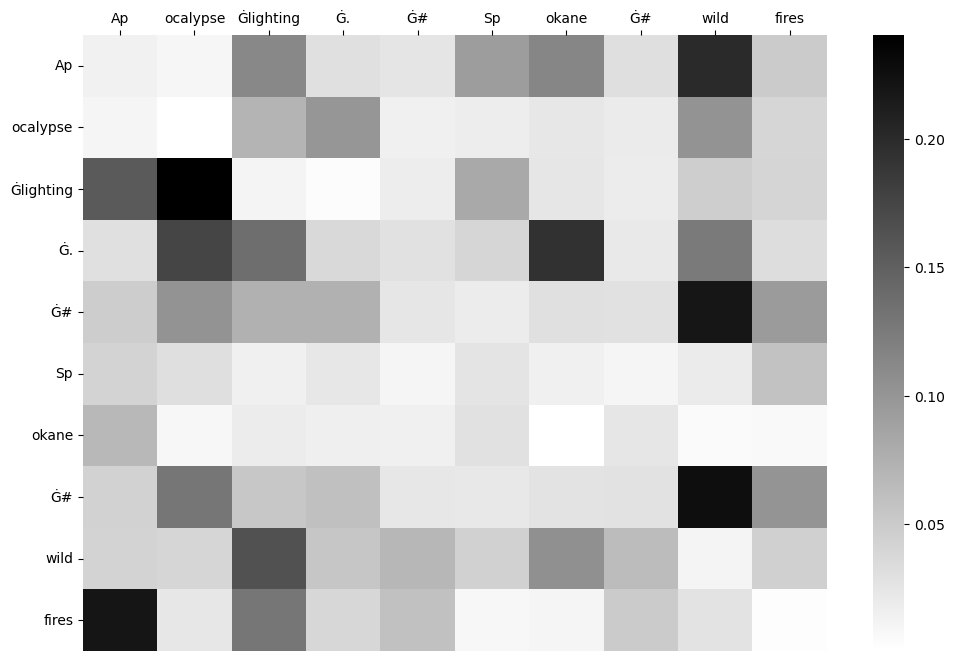

In [213]:
# Compute the attention map, for the third tweet in the test set, on the 11th head of the 1st multi-head layer
ComputeAttentionMaps(dataset = TestDataset, model = BERTweetlarge, tokenizer = BERTweetlarge_tokenizer, input_id = 3, multiheadlayer_no = 0, head_no = 10)

Device: mps


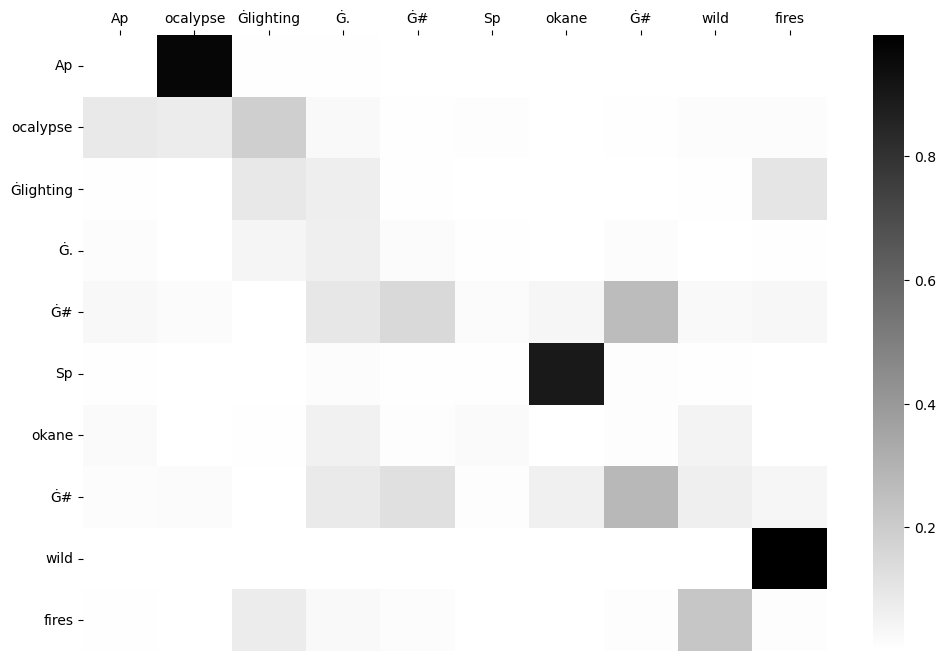

In [187]:
# Compute the attention map, for the third tweet in the test set, on the 5th head of the 3rd multi-head layer
ComputeAttentionMaps(dataset = TestDataset, model = BERTweetlarge, tokenizer = BERTweetlarge_tokenizer, input_id = 3, multiheadlayer_no = 2, head_no = 4)